# Kaggle Competition

# Table of Contents

1. [Titanic - Machine Learning from Disaster](#ch1)
1. [Deep Dive - Exploratory Data Analysis (EDA)](#ch2)
   1. [Concise summary of the data](#ch2.1)
   1. [Data visualization and analysis](#ch2.2)
1. [Section 3](#section-3)
   - [Subsection 3.1](#subsection-31)
   - [Subsection 3.2](#subsection-32)

<a id="ch1"></a>
# Titanic - Machine Learning from Disaster

![Description of image](Images\Titanic.png)

cite https://www.cleanpng.com/png-sinking-of-the-rms-titanic-titanic-honor-and-glory-2205845/download-png.html

The sinking of the Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew. While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others ([Cukierski 2012](#Bibliography)). 


#### Dataset Description
| Variable  | Definition                                  | Key                                        |
|-----------|--------------------------                   |--------------------------------------------|
| survival  | Survival                                    | 0 = No, 1 = Yes                            |
| pclass    | Ticket class                                | 1 = 1st, 2 = 2nd, 3 = 3rd                  |
| sex       | Sex                                         |                                            |
| Age       | Age in years                                |                                            |
| sibsp     | # of siblings / spouses aboard the Titanic  |                                            |
| parch     | # of parents / children aboard the Titanic  |                                            |
| ticket    | Ticket number                               |                                            |
| fare      | Passenger fare                              |                                            |
| cabin     | Cabin number                                |                                            |
| embarked  | Port of Embarkation                         | C = Cherbourg, Q = Queenstown, S = Southampton |


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score

from termcolor import colored

sns.set_theme(style="whitegrid")

train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")

plot_data = train.copy(deep=True)
plot_data["Survived"].replace(to_replace={0: "No", 1: "Yes"}, inplace=True)


In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## First Glimpse

How many people survived and did societal norms and priorities play a role during this tragic event?

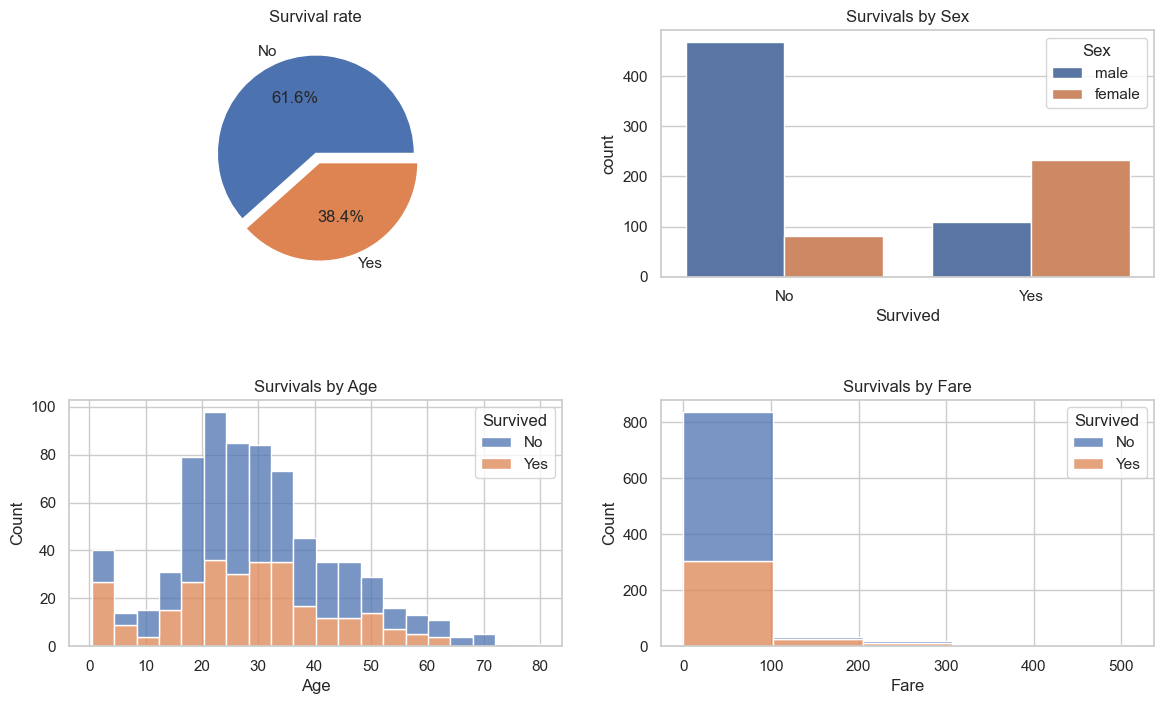

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
plot_data['Survived'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax[0, 0])
ax[0, 0].set_title('Survival rate')
ax[0, 0].set_ylabel('')
sns.countplot(data=plot_data, x="Survived", hue="Sex", ax=ax[0, 1])
ax[0, 1].set_title('Survivals by Sex')
sns.histplot(data=plot_data, x="Age", hue="Survived", multiple="stack", bins=20, ax=ax[1, 0])
fig.subplots_adjust(hspace=0.5)
ax[1, 0].set_title('Survivals by Age')
sns.histplot(data=plot_data, x="Fare", hue="Survived", multiple="stack", bins=5, ax=ax[1, 1])
ax[1, 1].set_title('Survivals by Fare')
plt.show()

Clearly, the survival rate of the accident was notably low. Of the 891 passengers in the training set only 350 managed to survive. However it becomes evident that specific attributes like sex, age and socioeconomic status significantly influenced the chances of survival.

Let's conduct a more thorough analysis to uncover valuable insights into the intricate dynamics that determined the fate of the passengers aboard the ill-fated Titanic.




<a id="ch2"></a>
# Deep Dive - Exploratory Data Analysis (EDA)


Exploratory Data Analysis (EDA) is a crucial phase in the data analysis process where the primary goal is to gain insights into the data set, understand its characteristics, and identify patterns or relationships among variables.

### Concise summary of the data

Get a concise summary of the DataFrame including the index, dtype, columns, non-null values and memory usage.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Data formats look reasonable. Looks like we are missing data for Age and Cabin though.

In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Indeed we do and quite so for Cabin (77%) and Age (20%). We will fix this after going over the features.

### Data visualization and analysis

#### Sex

Sex is a categorical feature. Categorical features encompass variables that contain two or more distinct categories. For instance, gender represents the categories 'male' and 'female'. It's important to note that these types of variables cannot be sorted or assigned any specific order. They are alternatively referred to as nominal variables.

In [6]:
display(pd.crosstab(index=plot_data["Sex"], columns=plot_data["Survived"]).style.set_caption('Survival by Sex'))
display(pd.crosstab(index=plot_data["Sex"], columns=plot_data["Survived"], normalize="index").style.set_caption('Survival rate per sex').\
    format("{:.2f}"))

Survived,No,Yes
Sex,,
female,81,233
male,468,109


Survived,No,Yes
Sex,,
female,0.26,0.74
male,0.81,0.19


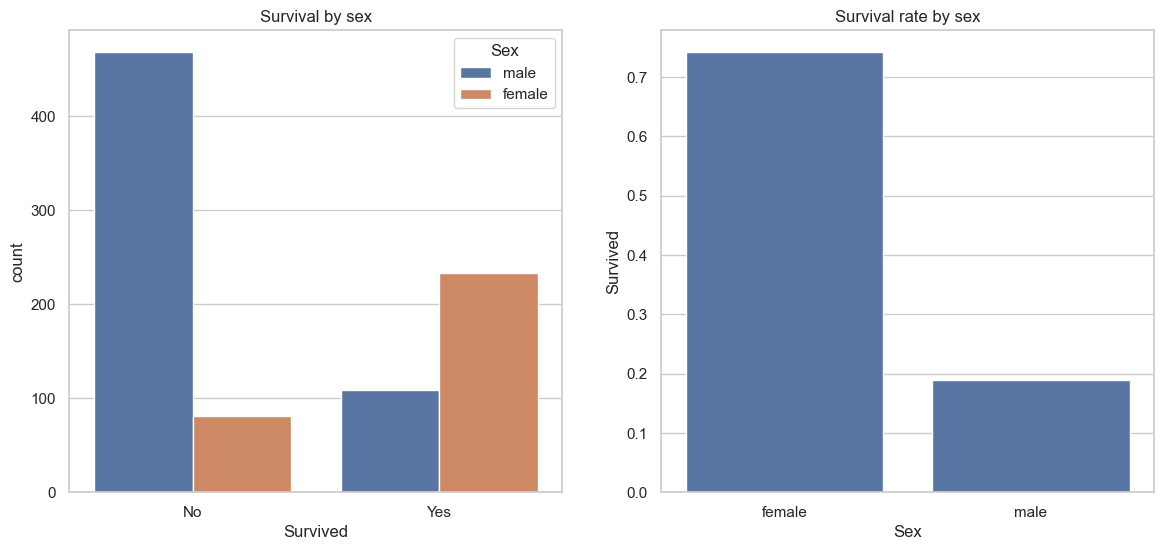

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.countplot(data=plot_data, x="Survived", hue="Sex", ax=ax[0])
ax[0].set_title("Survival by sex")
sns.barplot(data=train[['Sex','Survived']].groupby(['Sex']).mean(), y="Survived", x="Sex", ax=ax[1])
ax[1].set_title("Survival rate by sex")
plt.show()

This is intriguing. Although there were significantly more men aboard the ship compared to women, the quantity of women saved is nearly double that of the men saved. This is also reflected in the survival rate, with women being nearly four times as likely to survive as men. **While women's survival rate on the ship is approximately 75%, men's survival rate is very low with just 19%**. 

The significant disparity can be accounted for by the implementation of the "women first" policy. This policy refers to prioritizing the rescue of women over men during the evacuation. This procedure aimed to protect the most vulnerable and was part of the maritime tradition of prioritizing the safety of women and children in life-threatening situations. 

This raises another question: who were the fortunate men and the unfortunate women in this context? Is there a pattern as well?

#### Passenger Class

Passanger Class is an ordinal feature. Ordinal features are similiar to categorical features, but with an added dimension of relative ordering or ranking between the values. Unlike regular categorical variables, ordinal features have an inherent order among the categories. For instance, if we consider a feature like Education Level with values such as High School, Bachelor's, Master's, and PhD, the feature Education Level would be considered an ordinal variable. In this case, the values can be arranged in a specific order, representing varying levels of education attainment. 


In [8]:
display(pd.crosstab(index=plot_data["Pclass"], columns=plot_data["Survived"], margins=True).style.set_caption('Survival by Passenger Class'))
display(pd.crosstab(index=plot_data["Pclass"], columns=plot_data["Survived"], margins=True, normalize="index").style.set_caption('Survival rate per Passenger Class').\
    format("{:.2f}"))

Survived,No,Yes,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


Survived,No,Yes
Pclass,,
1,0.37,0.63
2,0.53,0.47
3,0.76,0.24
All,0.62,0.38


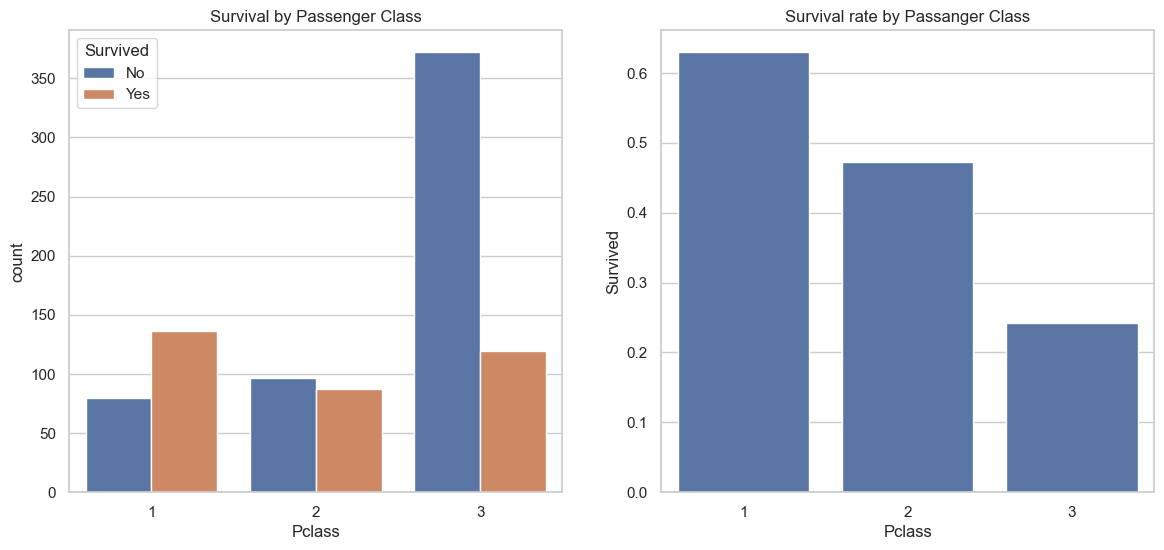

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.countplot(data=plot_data, x="Pclass", hue="Survived", hue_order= ["No", "Yes"], ax=ax[0])
ax[0].set_title("Survival by Passenger Class")
sns.barplot(data=train[['Pclass','Survived']].groupby(['Pclass']).mean(), y="Survived", x="Pclass", ax=ax[1])
ax[1].set_title("Survival rate by Passanger Class")
plt.show()

People say that money cannot buy everything. However, it is evident that during the rescue efforts, passengers belonging to a higher socioeconomic status were granted significantly higher priority. This is especially reflected in the very low survival rate of passenger in the **third class, with just about 25%**.

But now is that question: did wealth and status also matter in regard of sex? Lets examine the survival rate together with **Sex and Passenger Class**.

In [10]:
print('Survival by Sex and Passenger Class')
plot_data.groupby(by=["Sex", "Pclass", "Survived"])["Survived"].count()

Survival by Sex and Passenger Class


Sex     Pclass  Survived
female  1       No            3
                Yes          91
        2       No            6
                Yes          70
        3       No           72
                Yes          72
male    1       No           77
                Yes          45
        2       No           91
                Yes          17
        3       No          300
                Yes          47
Name: Survived, dtype: int64

In [11]:
grouped_sex_pclass_df  = train.groupby(by=['Sex', 'Pclass']).agg(Survivors = pd.NamedAgg(column='Survived', aggfunc="sum"), Passengers = pd.NamedAgg(column='Survived', aggfunc="size"))
grouped_sex_pclass_df['Survival_Rate'] = grouped_sex_pclass_df['Survivors'] / grouped_sex_pclass_df['Passengers']

print('Survival rate by Sex and Passenger Class')
display(grouped_sex_pclass_df.style.format({'Survival_Rate':'{:.2%}'}))

Survival rate by Sex and Passenger Class


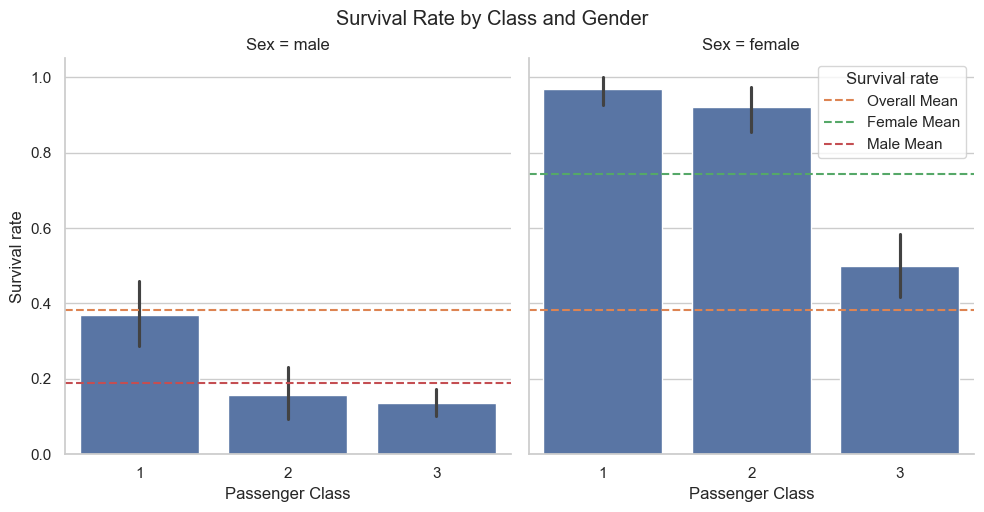

In [12]:
fig = sns.catplot(data=train, x="Pclass", y="Survived", col="Sex", kind="bar")

# display mean survival rate for male and female
# choose colors from sns.color_palette().as_hex for mean values
red = (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)
orange = (0.8666666666666667, 0.5176470588235295, 0.3215686274509804)
green = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)


for ax in fig.axes.flat:
    ax.axhline(y=train['Survived'].mean(), color=orange, linestyle='--', label='Overall Mean')
    if ax.get_title() == 'Sex = male':
        ax.axhline(y=train[train['Sex'] == 'male']['Survived'].mean(), color=red, linestyle='--', label='Male Mean')
    elif ax.get_title() == 'Sex = female':
        ax.axhline(y=train[train['Sex'] == 'female']['Survived'].mean(), color=green, linestyle='--', label='Female Mean')


#create single legend for subplots
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes.flat]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#specify order of items in legend and omit duplicate label of overall mean
order = [0, 3, 1]
plt.legend(handles=[handles[idx] for idx in order], labels=[labels[idx] for idx in order], title="Survival rate") 


fig.set_axis_labels(x_var="Passenger Class", y_var="Survival rate")
plt.suptitle("Survival Rate by Class and Gender", y=1.02)
plt.show()

 It is evident that irrespective of Passenger class, women were given first priority during the rescue. However money and status were a crucial factor within the groups. The chance of survival virtually doubled for men in Passenger Class 1, coming close to the overall mean. The importance of socioeconomic status becomes even more visible for women, nearly all passangers of the first and second class made it out alive, while in the third class only half the women managed to survive, approaching the overall mean. 
 
 **So women first and rich second**?

#### Age

Age is an continous feature. Continuous features refer to variables that can take on any numerical value within a certain range. In other words, there are no restrictions on the values that a continuous feature can assume between any two points or within the minimum and maximum values in the feature column. Common examples are: temperature, weight, and height. 

In [13]:
display(train[["Age"]].describe().style.format({'Age':'{:.1f}'}))

,Age
count,714.0
mean,29.7
std,14.5
min,0.4
25%,20.1
50%,28.0
75%,38.0
max,80.0


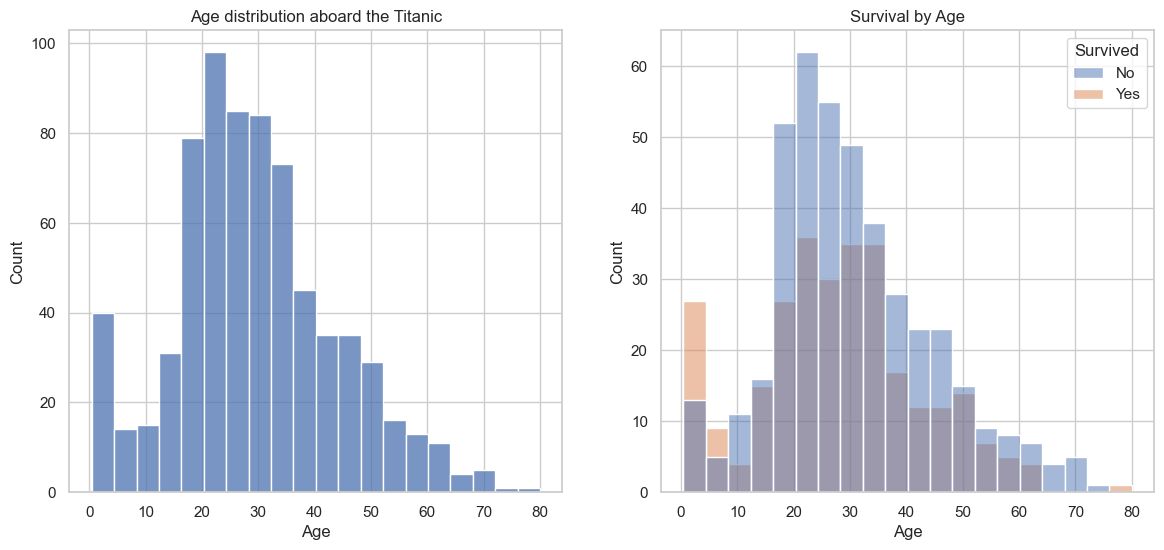

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.histplot(data=plot_data, x="Age", multiple="layer", bins=20, ax=ax[0])
ax[0].set_title("Age distribution aboard the Titanic")
sns.histplot(data=plot_data, x="Age", hue="Survived", multiple="layer", bins=20, ax=ax[1])
ax[1].set_title("Survival by Age")
plt.show()

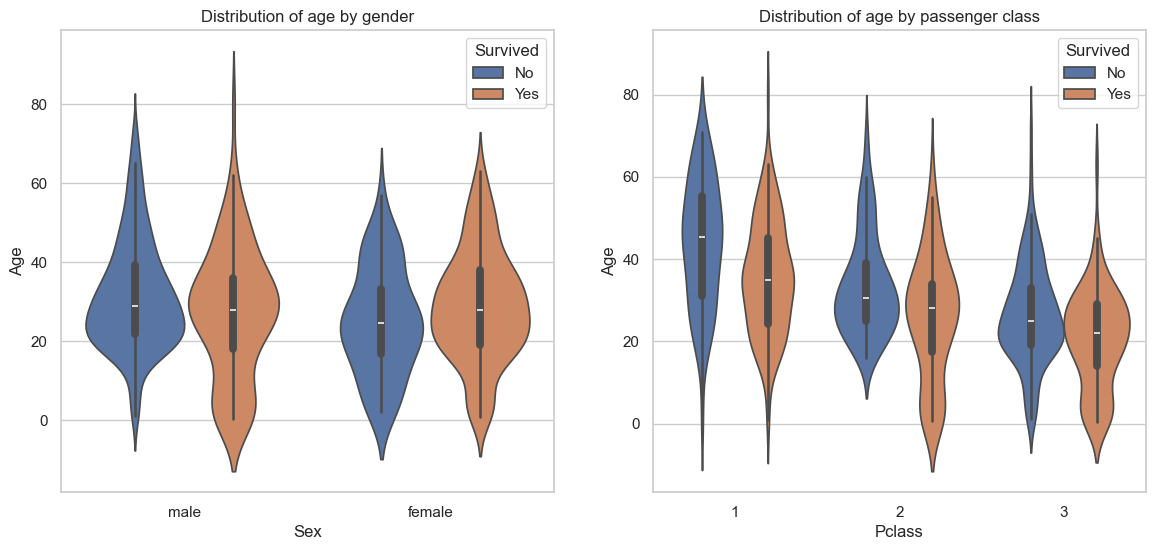

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.violinplot(data=plot_data, x="Sex", y="Age", hue="Survived", ax=ax[0])
ax[0].set_title("Distribution of age by gender")
sns.violinplot(data=plot_data, x="Pclass", y="Age", hue="Survived", hue_order= ["No", "Yes"], ax=ax[1])
ax[1].set_title("Distribution of age by passenger class")
plt.show()

Swarmplot gives a better representation of the distribution of values, but it does not scale well to large numbers of observations.

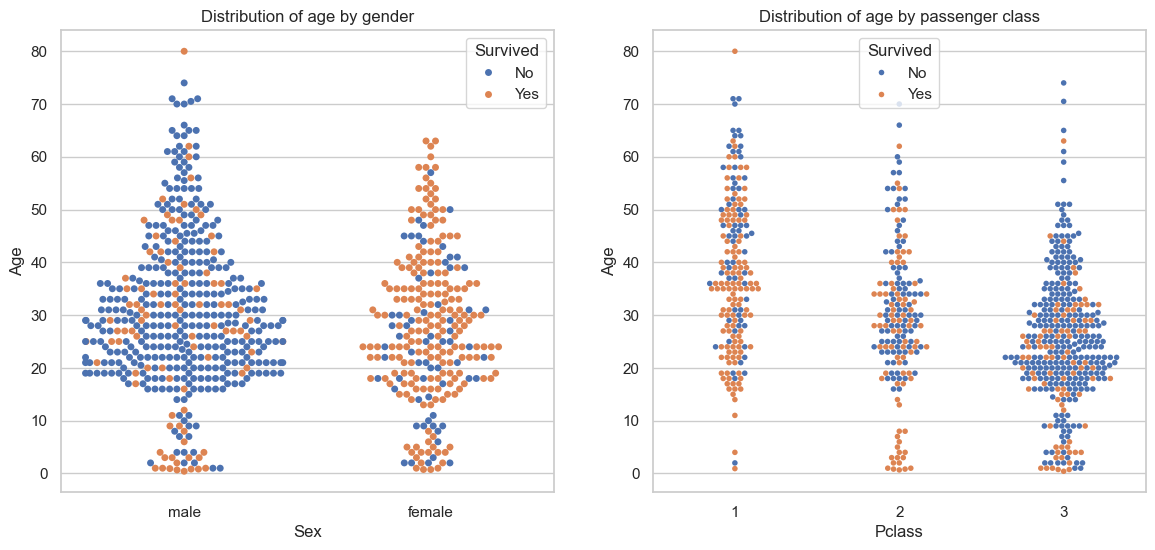

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.swarmplot(data=plot_data, x="Sex", y="Age", hue="Survived", size=5, ax=ax[0])
ax[0].set_title("Distribution of age by gender")
sns.swarmplot(data=plot_data, x="Pclass", y="Age", hue="Survived", hue_order= ["No", "Yes"], size=4, ax=ax[1])
ax[1].set_title("Distribution of age by passenger class")
plt.show()

It appears that prioritizing the safety of children, regardless of their gender, was a primary concern — the well-known "women and children first" policy.  However it looks like that while the gender did not matter the status of your parents did. Let's investigate this further.


In [17]:
df_children = train[train["Age"] <= 16]
children_stats = df_children.groupby(by=['Sex']).agg(Survivors = pd.NamedAgg(column='Survived', aggfunc="sum"),Passengers = pd.NamedAgg(column='Survived', aggfunc="size"), Survival_Rate_children =pd.NamedAgg(column="Survived", aggfunc="mean"))
children_stats["Overall Survival Rate by gender"] = [train[train['Sex'] == 'female']['Survived'].mean(), train[train['Sex'] == 'male']['Survived'].mean()]
children_stats["Overall Survival Rate"] = train['Survived'].mean()
children_stats["Overall Survival Rate children"] = df_children["Survived"].mean()

children_stats
print('Survival rate of children by Sex')
display(children_stats.style.format({'Survival_Rate':'{:.2%}'}))

Survival rate of children by Sex


,Survivors,Passengers,Survival_Rate_children,Overall Survival Rate by gender,Overall Survival Rate,Overall Survival Rate children
Sex,,,,,,
female,33,49,0.673469,0.742038,0.383838,0.550000
male,22,51,0.431373,0.188908,0.383838,0.550000


One can see that the survival rate of children (55%) is clearly higher than the overall average (38%). However while the chance of survival of boys more than doubled (from 19% to 43%), the survival rate of girls is actually slightly lower than the female average (67% against 74%). 

How can that be explained? And which role did the status of your parents play?


In [86]:
print('Survival rate of children by Sex and Passanger Class')
df_children.groupby(by=['Sex', 'Pclass']).agg(Survivors = pd.NamedAgg(column='Survived', aggfunc="sum"),Passengers = pd.NamedAgg(column='Survived', aggfunc="size"), Survival_Rate =pd.NamedAgg(column="Survived", aggfunc="mean"))

Survival rate of children by Sex and Passanger Class


Survivors  Passengers  Survival_Rate
Sex    Pclass                                      
female 1               5           6       0.833333
       2              10          10       1.000000
       3              18          33       0.545455
male   1               3           3       1.000000
       2               9          11       0.818182
       3              10          37       0.270270

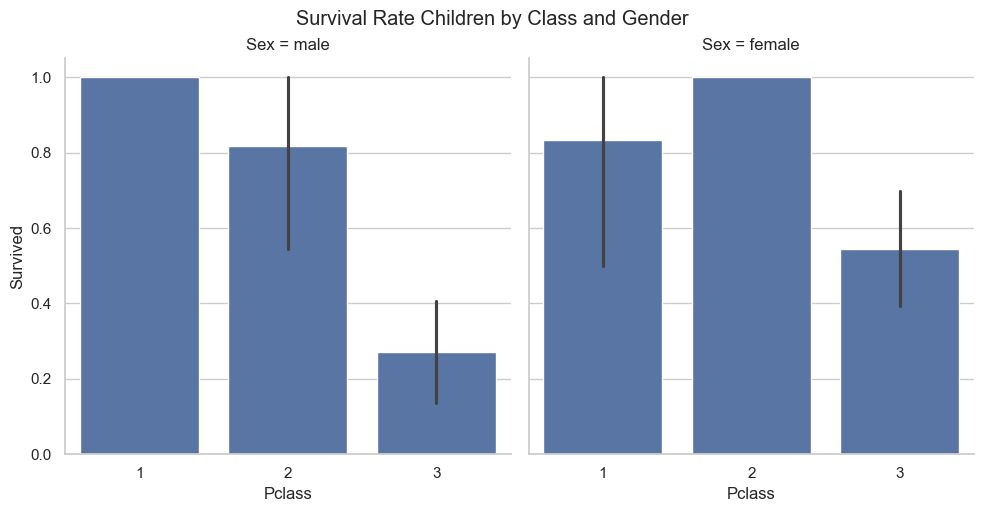

In [87]:
sns.catplot(data=df_children, x="Pclass", y="Survived", col="Sex", kind="bar")
plt.suptitle("Survival Rate Children by Class and Gender", y=1.02)
plt.show()

It appears that prioritizing the safety of children, regardless of their gender, was a primary concern. However while the gender did not matter the status of your parents did. Almost all children travelling in the first and second passenger class survived whereas children in the third passanger class were not so lucky. Being a child did not matter so much when your parents had low socioeconomic status. Once again, financial status played an important role, even in the context of children's survival.

#### Embarked

Embarked is also a categorical feature. This means there is no ranking between the values.

In [91]:
print('Survivals by Embarkment and Pclass')
pd.crosstab([plot_data.Embarked, plot_data.Pclass],[plot_data.Sex, plot_data.Survived],margins=True).style.background_gradient(cmap='summer_r')

Survivals by Embarkment and Pclass


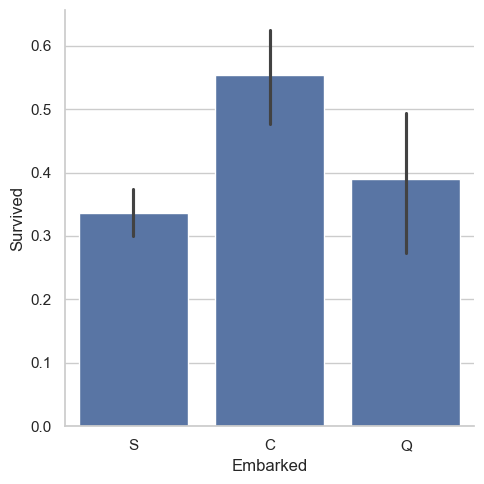

In [21]:
fig = sns.catplot(data=train, x="Embarked", y="Survived", kind="bar")
plt.show()

Port C has the highest survival probability at approximately 0.55, whereas S has the lowest. Yet, is this discrepancy attributed to the port itself or other contributing factors?

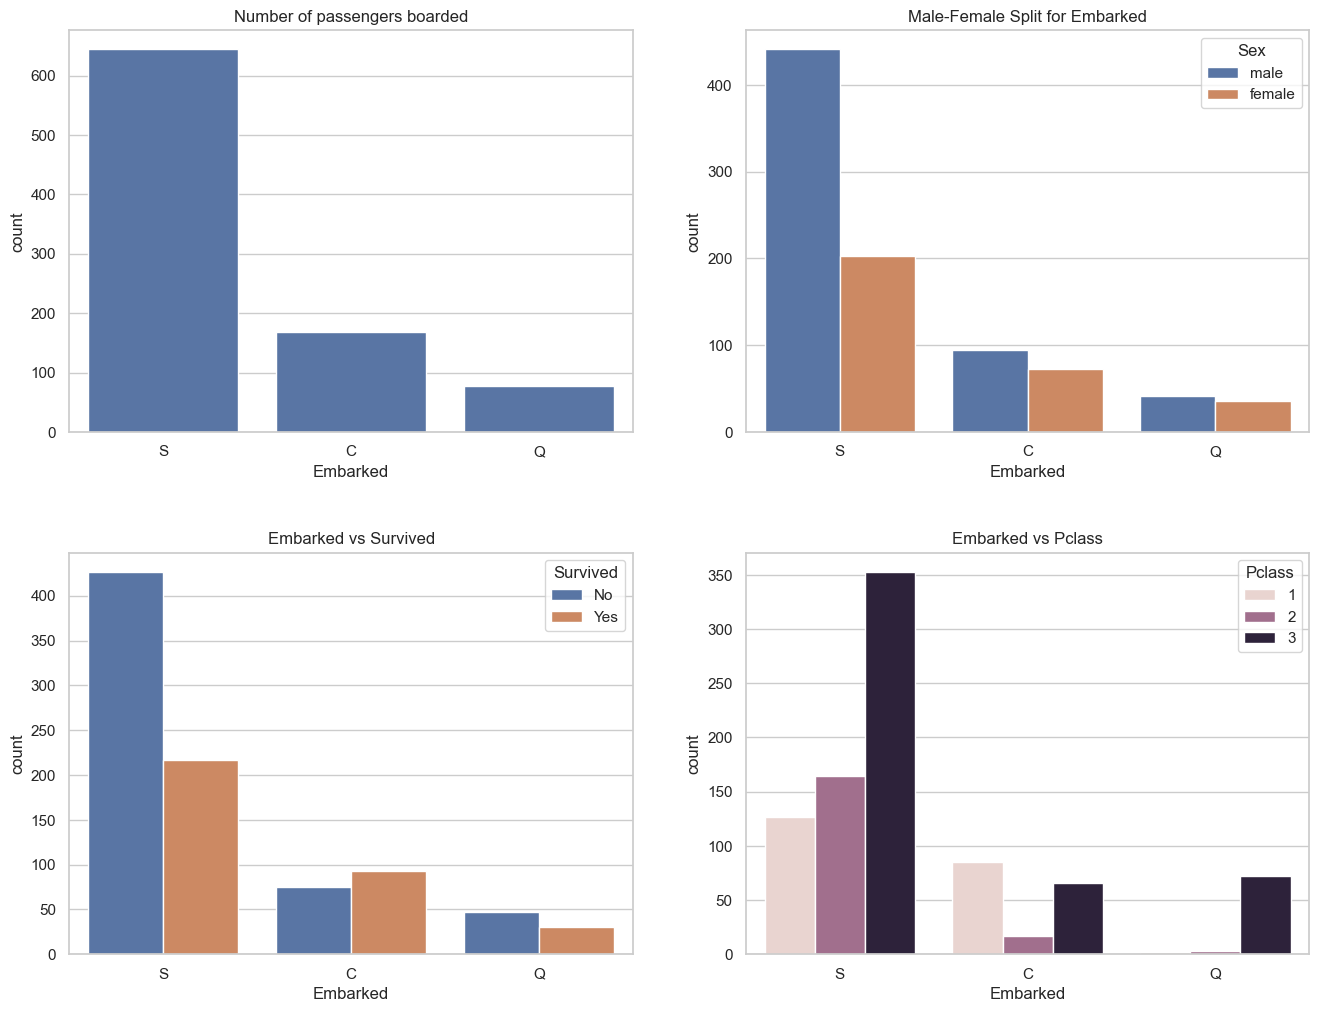

In [22]:
fig, ax = plt.subplots(2,2,figsize=(16,12))
sns.countplot(data=plot_data, x='Embarked',ax=ax[0,0])
ax[0,0].set_title('Number of passengers boarded')
sns.countplot(data=plot_data, x='Embarked',hue='Sex',ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')
sns.countplot(data=plot_data, x='Embarked',hue='Survived',ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')
sns.countplot(data=plot_data, x='Embarked',hue='Pclass',ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

The majority of passengers boarded from Southampton, primarily from Pclass3. Passengers from Cherbourg experienced a higher survival rate, potentially attributed to the rescue of all Pclass1 and Pclass2 passengers. Despite being popular among wealthy passengers, embarkation at Southampton correlated with lower survival chances, notably with around 81% of Pclass3 passengers not surviving. Port Queenstown had an overwhelming presence of Pclass3 passengers, constituting nearly 95% of the total. 

It kind of seems like Passanger Class and Sex are the decisive factors. Let's examine this:

In [23]:
grouped_sex_pclass_embarked_df  = train.groupby(by=['Sex', 'Pclass', 'Embarked']).agg(Survivors = pd.NamedAgg(column='Survived', aggfunc="sum"), Passengers = pd.NamedAgg(column='Survived', aggfunc="size"))
grouped_sex_pclass_embarked_df['Survival_Rate'] = grouped_sex_pclass_embarked_df['Survivors'] / grouped_sex_pclass_embarked_df['Passengers']

print('Survival rate by Sex, Passenger Class and Embarked')
display(grouped_sex_pclass_embarked_df.style.format({'Survival_Rate':'{:.2%}'}))

Survival rate by Sex, Passenger Class and Embarked


The evaluation reveals the same general trends that we observed before regardless of embarkation location: females exhibit higher survival rates than males and survival rates show a decreasing trend with reduced passenger class.

Nevertheless, one notable observation emerges. The embarkation location appears to influence survival rates within the third passenger class. Approximately 70% of women boarding in Queenstown and Cherbourg survived, contrasting with a lower survival rate of 38% for those embarking in Southampton. One can assume a trend based on embarkation location for males as well.

#### SibSp: Number of siblings / spouses aboard the Titanic 

SibSp represents the number of siblings or spouses aboard the Titanic for each passenger. It is a discrete numerical feature, as it counts the number of individuals, taking on whole, non-negative values. This variable is integral to understanding family structures on the Titanic and can be used to explore the impact of traveling with siblings or spouses.

In [92]:
print('Survival based on Number of siblings / spouses')
pd.crosstab([plot_data["SibSp"]], plot_data["Survived"])

Survival based on Number of siblings / spouses


Survived,No,Yes
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


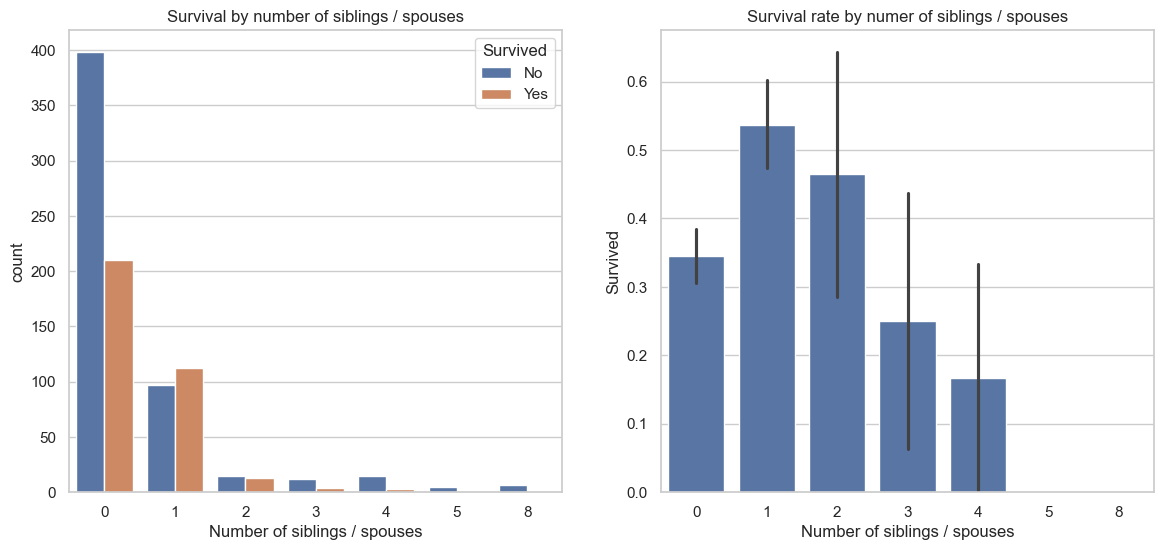

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.countplot(data=plot_data, x="SibSp", hue="Survived", hue_order= ["No", "Yes"], ax=ax[0])
ax[0].set_title("Survival by number of siblings / spouses")
ax[0].set(xlabel='Number of siblings / spouses')
sns.barplot(data=train, x="SibSp", y="Survived", ax=ax[1])
ax[1].set(xlabel='Number of siblings / spouses')
ax[1].set_title("Survival rate by numer of siblings / spouses")
plt.show()

In [94]:
#TODO: Check and Rewrite this


The barplot and factorplot reveal a noteworthy trend: when passengers are alone without any siblings onboard, their survival rate is 34.5%. The trend appears to decline as the number of siblings increases, suggesting an understandable pattern – individuals with family ties may prioritize saving their relatives over themselves during an emergency. Intriguingly, survival rates for families with 5-8 members drop to 0%. This anomaly prompts consideration of the role of Pclass.

#### Parch: Number of parents / children aboard the Titanic 

Parch is also a discrete numerical feature. Parch stands for the number of parents or children aboard the Titanic for each passenger.

In [95]:
print('Survival based on number of parents / children')
pd.crosstab([plot_data["Parch"]], plot_data["Survived"])

Survival based on number of parents / children


Survived,No,Yes
Parch,,
0,445,233
1,53,65
2,40,40
3,2,3
4,4,0
5,4,1
6,1,0


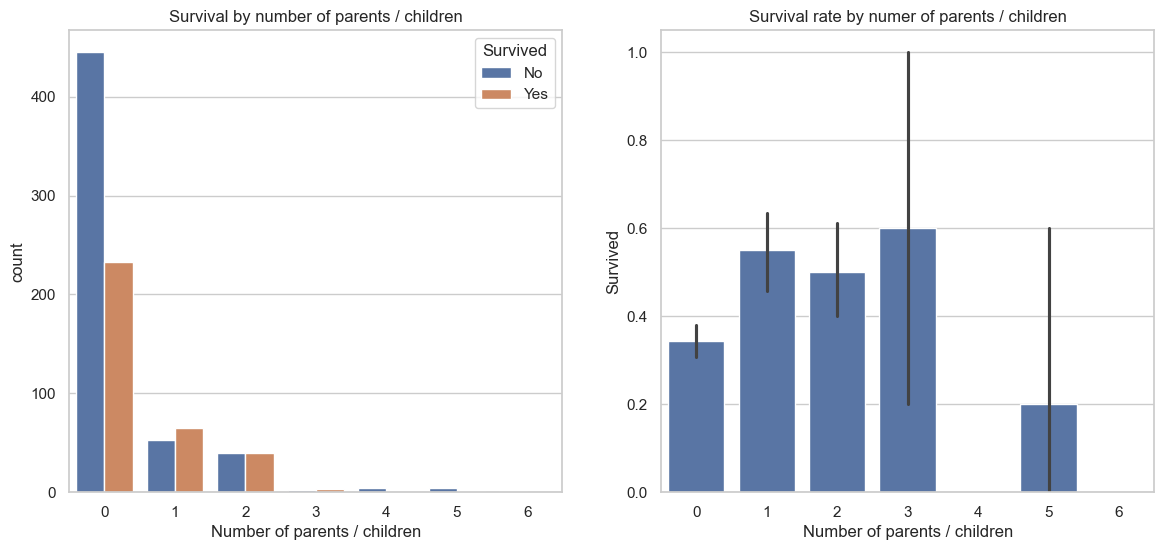

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.countplot(data=plot_data, x="Parch", hue="Survived", hue_order= ["No", "Yes"], ax=ax[0])
ax[0].set_title("Survival by number of parents / children")
ax[0].set(xlabel='Number of parents / children')
sns.barplot(data=train, x="Parch", y="Survived", ax=ax[1])
ax[1].set(xlabel='Number of parents / children')
ax[1].set_title("Survival rate by numer of parents / children")
plt.show()

In [96]:
#TODO: Check and Rewrite this

Similarly, findings indicate that passengers with parents onboard experience a higher likelihood of survival, although the probability diminishes with an increasing number. Favorable survival odds are observed for those with 1-3 parents onboard. Conversely, traveling alone proves to be precarious, and the probability of survival decreases notably when an individual has more than four parents accompanying them on the ship.

### Observations in a Nutshell 

Gender significantly influences survival chances, with women having notably higher survival rates than men.

Passenger Class (Pclass) reveals a clear pattern: 1st class passengers enjoy better survival prospects, whereas Pclass3 experiences a markedly low survival rate. For women, the likelihood of survival is nearly 100% in Pclass1, and it remains high in Pclass2. Money seems to be a deciding factor.

Age plays a critical role, with children aged 5-10 exhibiting high survival chances. Conversely, passengers between 15 and 35 face elevated mortality rates.

Embarked location adds an intriguing dimension. Despite the majority of Pclass1 passengers embarking at S, the survival rate at C appears better. Notably, passengers at Q are exclusively from Pclass3, correlating with lower survival rates.

#TODO: CHeck this:
Family presence (Parch + SibSp) indicates that having 1-2 siblings or a spouse on board, as well as 1-3 parents, enhances the likelihood of survival. Traveling alone or with a large family diminishes survival probabilities.

## **Feature engineering**

Feature engineering is the process of transforming raw data into a format that is more suitable for machine learning models, with the goal of improving the performance of those models. It involves creating new features, selecting relevant features, and modifying existing features to enhance the model's ability to make accurate predictions or classifications.

### **Impute missing values** 

#### **Age**

Previously, we identified 177 null values in the Age feature and suggested replacing them with the dataset's mean age. However, assigning a universal mean age may not be practical, given the diverse age range. 

A solution lies in examining the Name feature, which includes salutations like Mr or Mrs. We can assign mean values of Mr and Mrs to their respective groups for a more nuanced approach. 
Additionally, we can refine this method by grouping age according to passenger classes. This is beneficial, considering the correlation between age and passenger class.


In [28]:
print("Number of missing values for Age:", train[["Age"]].isnull().sum())

Number of missing values for Age: Age    177
dtype: int64


In [29]:
# feature engineering create a new feature derived on the initials in name
train["Title"] = train["Name"].str.extract('([A-Za-z]+)\.')

In [30]:
pd.crosstab(train['Title'], train['Sex']).transpose()

Title,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [31]:
train.groupby('Title')['Age'].agg(["count", "mean"])

,count,mean
Title,,
Capt,1,70.000000
Col,2,58.000000
Countess,1,33.000000
Don,1,40.000000
Dr,6,42.000000
Jonkheer,1,38.000000
Lady,1,48.000000
Major,2,48.500000
Master,36,4.574167



Certain initials, such as Mlle or Mme, most likely represent Miss and have been misspelled. I'll correct these and address similar issues with other values.

In [32]:
train['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [33]:
train.groupby('Title')['Age'].agg(["count", "mean"])

,count,mean
Title,,
Master,36,4.574167
Miss,150,21.860000
Mr,409,32.739609
Mrs,110,35.981818
Other,9,45.888889


In [34]:
train.groupby(by=['Title','Pclass'])['Age'].agg(["count", "mean"])

count       mean
Title  Pclass                  
Master 1           3   5.306667
       2           9   2.258889
       3          24   5.350833
Miss   1          48  29.625000
       2          33  22.560606
       3          69  16.123188
Mr     1          96  42.171875
       2          84  32.904762
       3         229  28.724891
Mrs    1          36  40.861111
       2          41  33.682927
       3          33  33.515152
Other  1           3  51.333333
       2           6  43.166667

In [35]:
missing_age_indices = train[train['Age'].isnull()].index

In [36]:
train.iloc[missing_age_indices]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,Mr
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,Mrs
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,Mr
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,Miss
...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C,Mr
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S,Miss
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S,Mr
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S,Mr


In [37]:
# Fill in missing age values based on title (derived from name) and passenger class
train['Age'] = train['Age'].fillna(train.groupby(by=['Title','Pclass'])['Age'].transform('mean').round(2))

In [38]:
#Check if imputation was done correctly
train.iloc[missing_age_indices]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
5,6,0,3,"Moran, Mr. James",male,28.72,0,0,330877,8.4583,NaN,Q,Mr
17,18,1,2,"Williams, Mr. Charles Eugene",male,32.90,0,0,244373,13.0000,NaN,S,Mr
19,20,1,3,"Masselmani, Mrs. Fatima",female,33.52,0,0,2649,7.2250,NaN,C,Mrs
26,27,0,3,"Emir, Mr. Farred Chehab",male,28.72,0,0,2631,7.2250,NaN,C,Mr
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,16.12,0,0,330959,7.8792,NaN,Q,Miss
...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,28.72,0,0,2629,7.2292,NaN,C,Mr
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,16.12,8,2,CA. 2343,69.5500,NaN,S,Miss
868,869,0,3,"van Melkebeke, Mr. Philemon",male,28.72,0,0,345777,9.5000,NaN,S,Mr
878,879,0,3,"Laleff, Mr. Kristo",male,28.72,0,0,349217,7.8958,NaN,S,Mr


In [39]:
train["Age"].isnull().any()

False

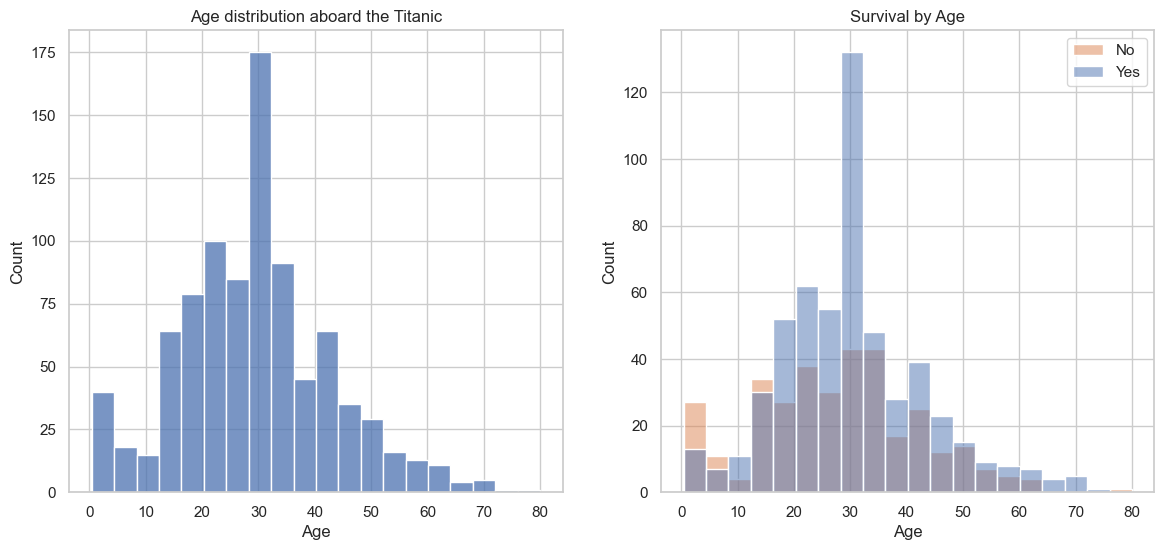

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.histplot(data=train, x="Age", multiple="layer", bins=20, ax=ax[0])
ax[0].set_title("Age distribution aboard the Titanic")
sns.histplot(data=train, x="Age", hue="Survived", multiple="layer", bins=20, ax=ax[1])
ax[1].set_title("Survival by Age")
plt.legend( loc='upper right', labels=['No', 'Yes'])
plt.show()

This looks good and corresponds well to our earlier age histograms.


#### Cabin
`Cabin` feature poses a bit of a challenge and needs further exploration. The mayority of the `Cabin` feature is missing and it cannot be disregarded entirely, as certain cabins may exhibit higher survival rates. The location of the cabin could be interesting for serval reasons:
- Proximity to lifeboats
- Accessibility to escape routes
- Impact location: Depending on the location of the cabin in relation to the point of impact with the iceberg, passengers in certain cabins might have faced different levels of danger and challenges in evacuating the ship.
- Water Ingress:  Cabins at lower levels or closer to the impact point may have experienced quicker and more severe water ingress, impacting the time available for evacuation.


It appears that the initial letter of the Cabin values corresponds to the decks where the cabins are situated. These decks were primarily designated for specific passenger classes, although some were utilized by multiple passenger classes ([Gunesevitan 2020](#Bibliography)).
![alt text](https://vignette.wikia.nocookie.net/titanic/images/f/f9/Titanic_side_plan.png/revision/latest?cb=20180322183733)



Lets' check if people were located differently based on passenger class and embarkment.



In [41]:
#Feature engineering "Deck" column based on the initial letter of the "Cabin" column, where "M" signifies missing values
train['Deck'] = train['Cabin'].str[0].fillna('M')
plot_data['Deck'] = plot_data['Cabin'].str[0].fillna('M')

In [42]:
train.groupby(by=["Deck","Pclass"])["Deck"].count()

Deck  Pclass
A     1          15
B     1          47
C     1          59
D     1          29
      2           4
E     1          25
      2           4
      3           3
F     2           8
      3           5
G     3           4
M     1          40
      2         168
      3         479
T     1           1
Name: Deck, dtype: int64

In [43]:
train.groupby(by=["Embarked", "Deck"])["Deck"].count()

Embarked  Deck
C         A         7
          B        22
          C        21
          D        13
          E         5
          F         1
          M        99
Q         C         2
          E         1
          F         1
          M        73
S         A         8
          B        23
          C        36
          D        20
          E        26
          F        11
          G         4
          M       515
          T         1
Name: Deck, dtype: int64

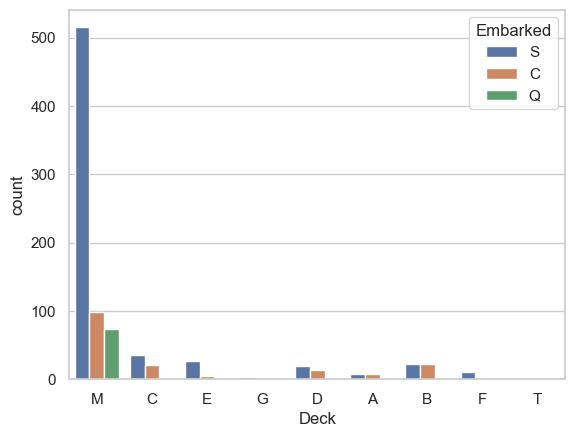

In [44]:
sns.countplot(data=plot_data, x="Deck", hue="Embarked")
plt.show()

As so many information for cabins is missing it is hard to tell if people were located on different decks based on the embarkment.

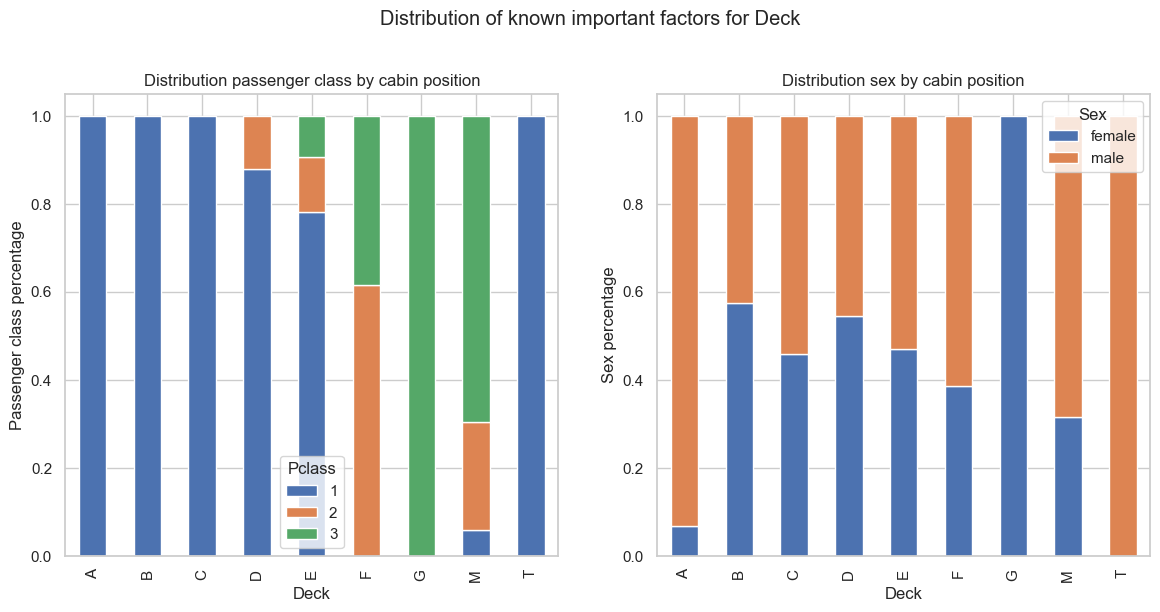

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plot_data.groupby('Deck')['Pclass'].value_counts(normalize=True).unstack('Pclass').plot.bar(stacked=True, ax=ax[0])
ax[0].set_ylabel("Passenger class percentage")
ax[0].set_title("Distribution passenger class by cabin position")
plot_data.groupby('Deck')['Sex'].value_counts(normalize=True).unstack('Sex').plot.bar(stacked=True, ax=ax[1])
ax[1].set_ylabel("Sex percentage")
ax[1].set_title("Distribution sex by cabin position")
plt.suptitle("Distribution of known important factors for Deck", y=1.02)
plt.show()

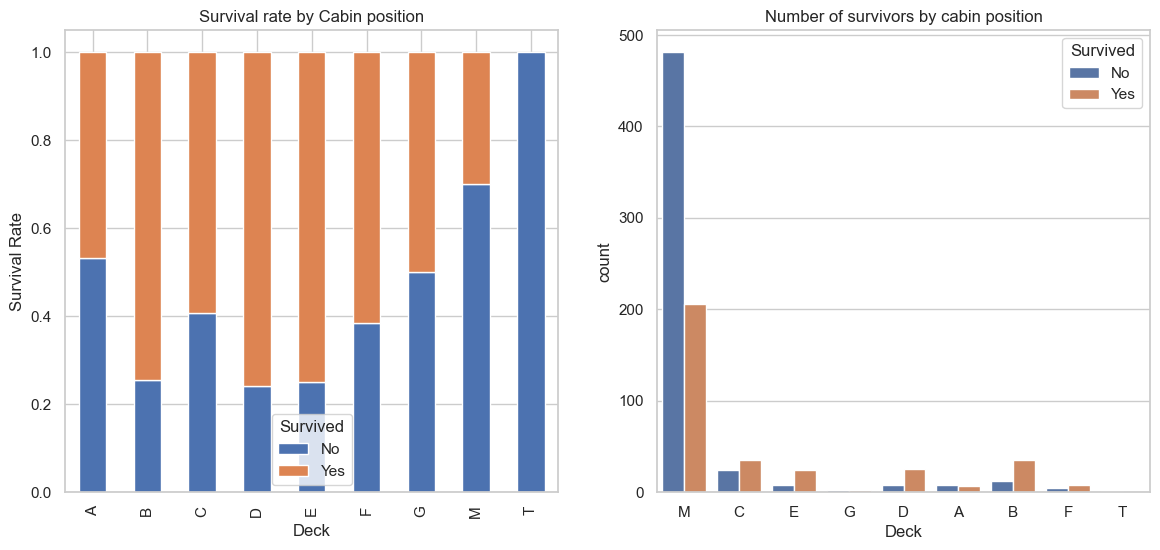

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plot_data.groupby('Deck')['Survived'].value_counts(normalize=True).unstack('Survived').plot.bar(stacked=True, ax=ax[0])
ax[0].set_ylabel("Survival Rate")
ax[0].set_title("Survival rate by Cabin position")
sns.countplot(data=plot_data, x="Deck", hue="Survived", ax=ax[1])
ax[1].set_title("Number of survivors by cabin position")
plt.show()


Observations:
* Deck **A**, **B** and **C**  were exclusively for 1st class passengers
* Deck **D** and **E** accomodated passengers of all classes
* Deck **F** and **G** decks were for both 2nd and 3rd class passengers
* From going **A** to **G**, distance to the staircase increases which might be a factor of survival

As suspected, there are distinct survival rate differences among various decks, making this information helpful. Decks B, C, D, and E exhibit the highest survival rates, primarily housing 1st class passengers. Interestingly enough Deck A, though exclusively for 1st class, has a low survival rate. This can be explained due to the high proportion of men and the "women first" policy. Another interesting observation is that Deck C and F have similar survival rates despite having different passenger classes and similar sex distribution. Cabins with no data (Deck M) were mainly occupied by 2nd and 3rd class passengers and have the lowest survival rate. 

With that we can drop Cabin and use Deck as a feature.

It's unclear if Deck is a significant factor itself or a surrogate for passenger class and sex, requiring further investigation into the Titanic sinking process. Some important questions to answer are:
- Where was the boat hit?
- How long did it take for the Titanic to sink?
- Where were the life boats located?
- Had everyone the chance to get on Deck to go to a lifeboat

In [47]:
missing_cabin_indices = train[train['Cabin'].isnull()].index

In [48]:
train.iloc[missing_cabin_indices] 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.2500,NaN,S,Mr,M
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,M
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.0500,NaN,S,Mr,M
5,6,0,3,"Moran, Mr. James",male,28.72,0,0,330877,8.4583,NaN,Q,Mr,M
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S,Master,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.00,0,0,SOTON/OQ 392076,7.0500,NaN,S,Mr,M
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.00,0,5,382652,29.1250,NaN,Q,Mrs,M
886,887,0,2,"Montvila, Rev. Juozas",male,27.00,0,0,211536,13.0000,NaN,S,Other,M
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,16.12,1,2,W./C. 6607,23.4500,NaN,S,Miss,M


In [49]:
# Based on our findings we group the passenger cabins into upper, middle and lower deck.
# Mapping for deck categories
deck_mapping = {"A": "Upper", "B": "Upper", "C": "Upper", "D": "Upper",
                "E": "Middle", "F": "Middle", "G": "Lower", "M": "M", "T": "Upper"}

train["Deck"] = train["Deck"].map(deck_mapping)

# Impute missing with upper for 1st Pclass, middle with 2nd Pclass and lower with 3rd Pclass
train.loc[(train["Deck"] =="M") & (train["Pclass"] ==1), "Deck"] = "Upper"
train.loc[(train["Deck"] =="M") & (train["Pclass"] ==2), "Deck"] = "Middle"
train.loc[(train["Deck"] =="M") & (train["Pclass"] ==3), "Deck"] = "Lower"

In [50]:
#Check if imputation was done correctly
train.iloc[missing_cabin_indices] 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.2500,NaN,S,Mr,Lower
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Lower
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.0500,NaN,S,Mr,Lower
5,6,0,3,"Moran, Mr. James",male,28.72,0,0,330877,8.4583,NaN,Q,Mr,Lower
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S,Master,Lower
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.00,0,0,SOTON/OQ 392076,7.0500,NaN,S,Mr,Lower
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.00,0,5,382652,29.1250,NaN,Q,Mrs,Lower
886,887,0,2,"Montvila, Rev. Juozas",male,27.00,0,0,211536,13.0000,NaN,S,Other,Middle
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,16.12,1,2,W./C. 6607,23.4500,NaN,S,Miss,Lower


In [51]:
train["Deck"].isnull().any()

False

In [52]:
train["Deck"].value_counts()

Deck
Lower     483
Middle    213
Upper     195
Name: count, dtype: int64

#### Embarked

The "Embarked" attribute is a categorical feature, and the entire dataset has only two missing values for this variable. Both instances involve female passengers of the upper class who share identical ticket numbers, suggesting a connection between them. 


In [53]:
missing_embarked_indices = train[train['Embarked'].isnull()].index

In [54]:
train.iloc[missing_embarked_indices] 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss,Upper
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs,Upper


While the most frequent Embarked value for an upper-class female passenger is C (Cherbourg), it does not conclusively indicate that they boarded the ship from that specific port.

According to ([Gunesevitan 2020](#Bibliography)) the passanger Stone, Mrs. George Nelson (Martha Evelyn) embarked from S (Southampton) with her maid Amelie Icard. 

In [55]:
train["Embarked"] = train["Embarked"].fillna("S")

### **Binning continous features**


Binning continuous features is a technique used in data analysis and machine learning to categorize continuous variables into discrete bins. This method helps in handling continuous attributes where it is more efficient or meaningful to deal with ranges of values rather than individual values. There are several methods and considerations when it comes to binning continuous features. We will simply split data into equal-sized groups.

#### **Fare**

In [56]:
train["Fare_Binned"] = pd.qcut(train['Fare'], 13)

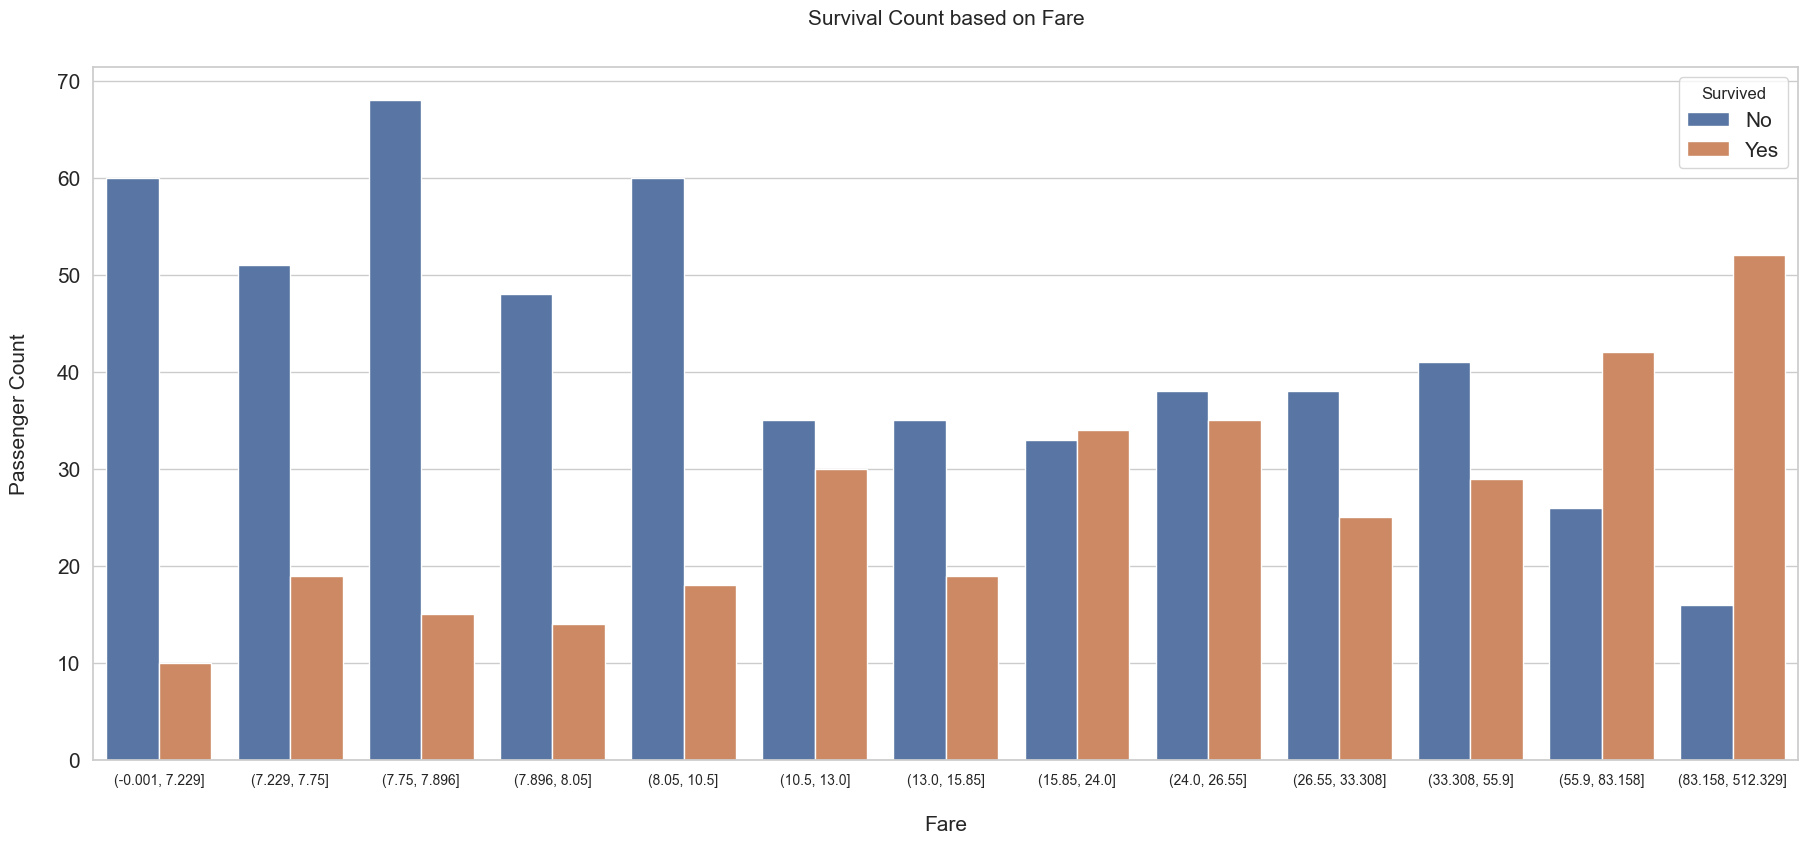

In [57]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare_Binned', hue='Survived',  data=train)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['No', 'Yes'], title="Survived", loc='upper right', prop={'size': 15})
plt.title('Survival Count based on Fare', size=15, y=1.05)

plt.show()

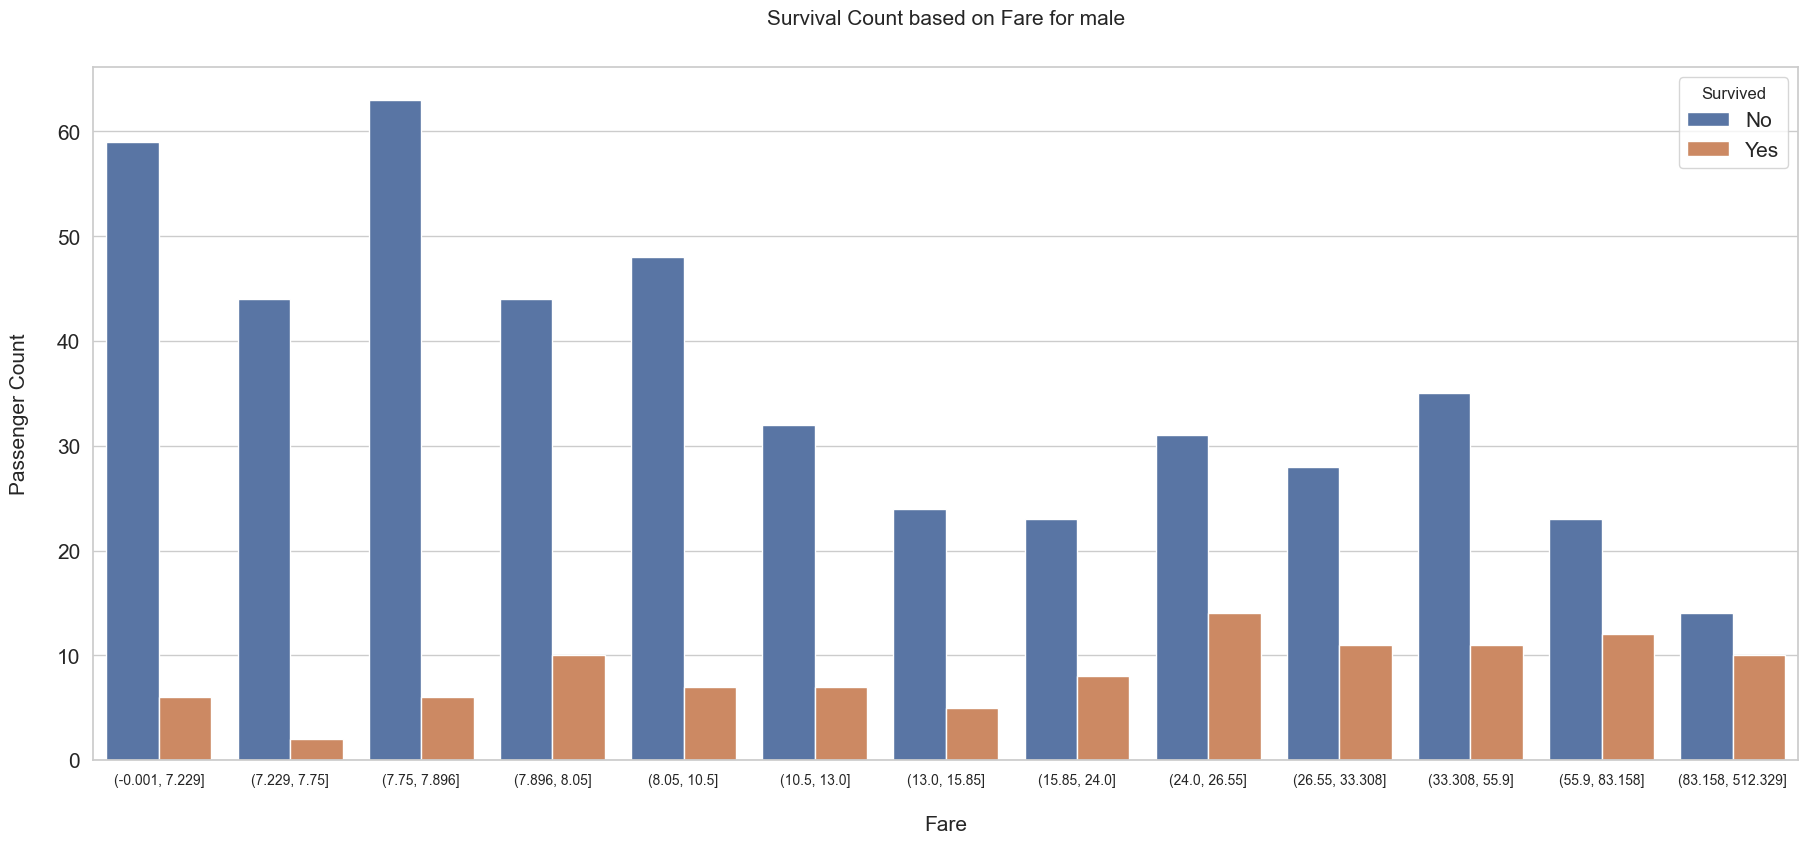

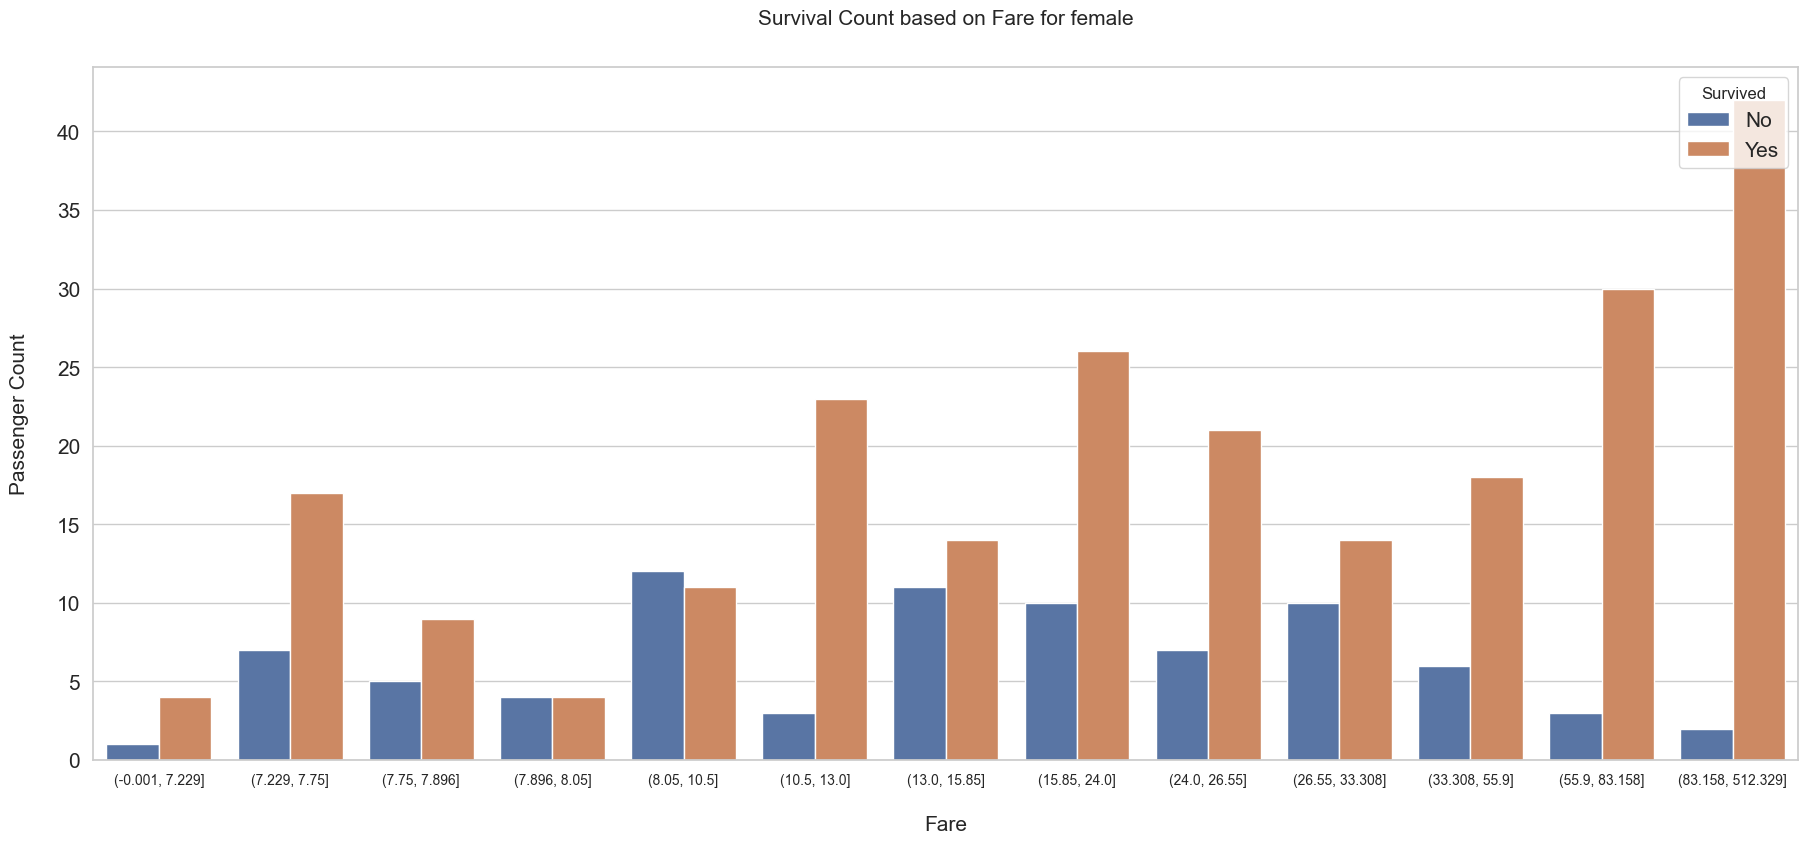

In [58]:
for gender in train['Sex'].unique():
    fig, axs = plt.subplots(figsize=(22, 9))
    sns.countplot(x='Fare_Binned', hue='Survived', data=train[train['Sex'] == gender])

    plt.xlabel('Fare', size=15, labelpad=20)
    plt.ylabel('Passenger Count', size=15, labelpad=20)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=15)

    plt.legend(['No', 'Yes'], title="Survived", loc='upper right', prop={'size': 15})
    plt.title(f'Survival Count based on Fare for {gender}', size=15, y=1.05)
    plt.show()

Fare, which closely relates to Passenger Class, unsurprisingly yields similar observations: Regardless of the fare amount, women were prioritized during the rescue operation. Nevertheless, within each group, financial means and social standing played a significant role. It's clear that the likelihood of survival noticeably improved for those paying higher fares.

#### **Age**

 Again we will simply split data into equal-sized groups.

In [59]:
train['Age_Binned'] = pd.qcut(train['Age'], 10)

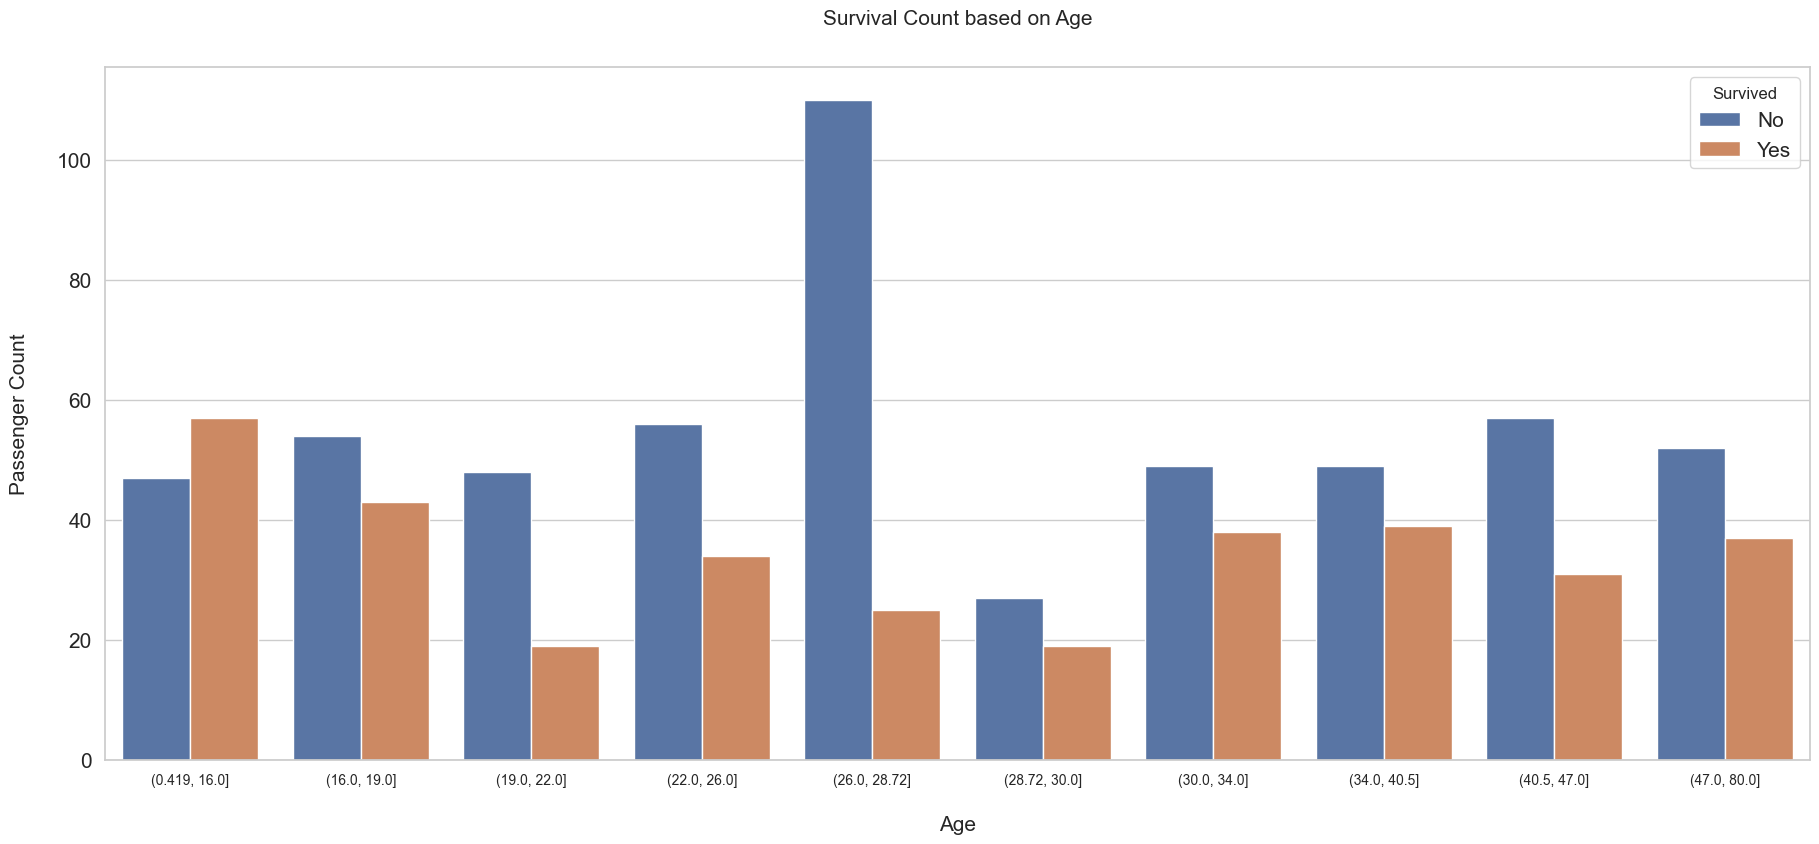

In [60]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age_Binned', hue='Survived',  data=train)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['No', 'Yes'], title="Survived", loc='upper right', prop={'size': 15})
plt.title('Survival Count based on Age', size=15, y=1.05)

plt.show()

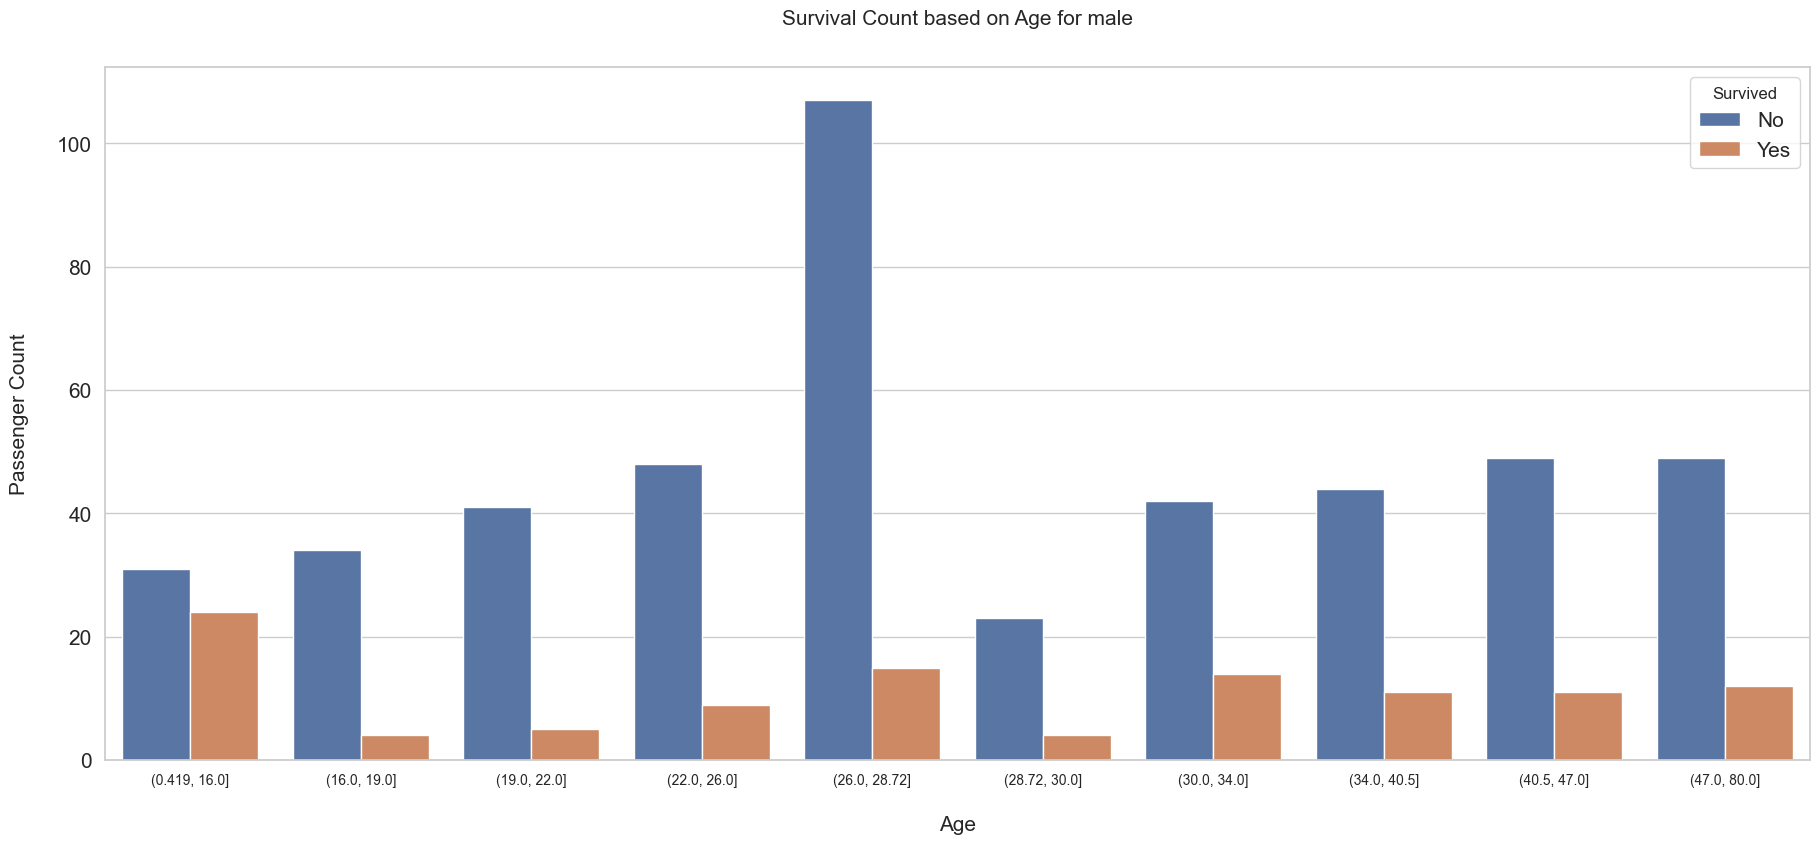

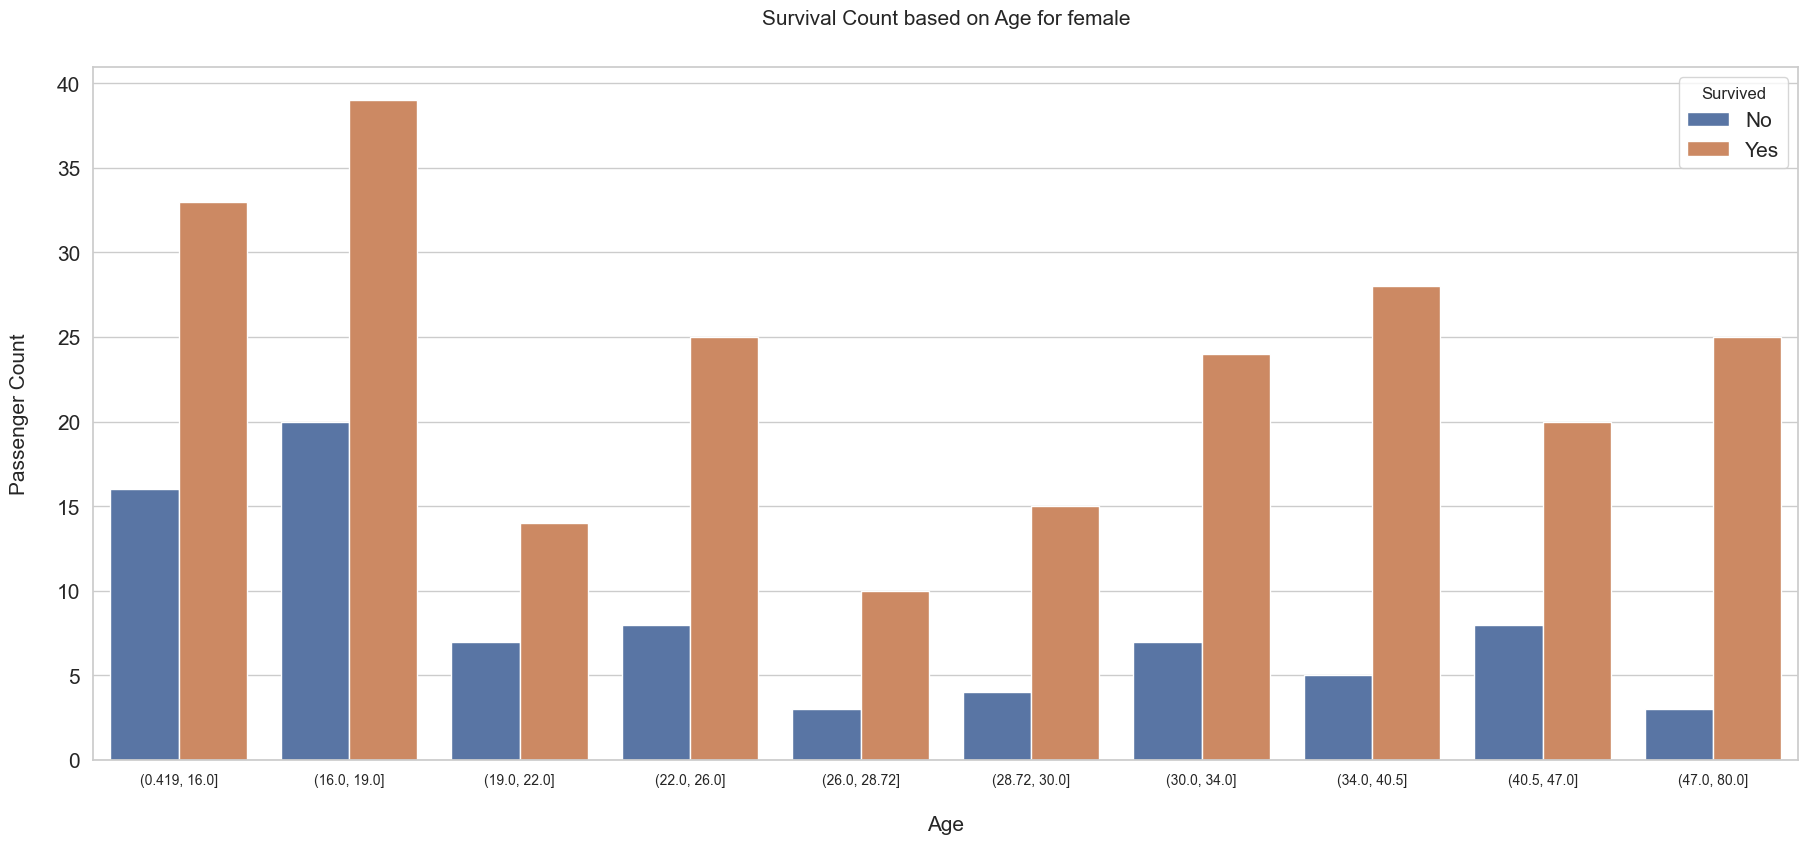

In [61]:
for gender in train['Sex'].unique():
    fig, axs = plt.subplots(figsize=(22, 9))
    sns.countplot(x='Age_Binned', hue='Survived', data=train[train['Sex'] == gender])

    plt.xlabel('Age', size=15, labelpad=20)
    plt.ylabel('Passenger Count', size=15, labelpad=20)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=15)

    plt.legend(['No', 'Yes'], title="Survived", loc='upper right', prop={'size': 15})
    plt.title(f'Survival Count based on Age for {gender}', size=15, y=1.05)
    plt.show()

As before we see that prioritizing the safety of children and women was a primary concern.


### **Feature Creation**

#### **Family_Size**
The 'Family_Size' attribute is derived by summing the values of 'SibSp', 'Parch'and plus 1 for the current passanger. Here, 'SibSp' represents the number of siblings and spouses aboard, while 'Parch' denotes the number of parents and children present. 

In [62]:
train['Family_Size'] = train['SibSp'] + train['Parch'] + 1

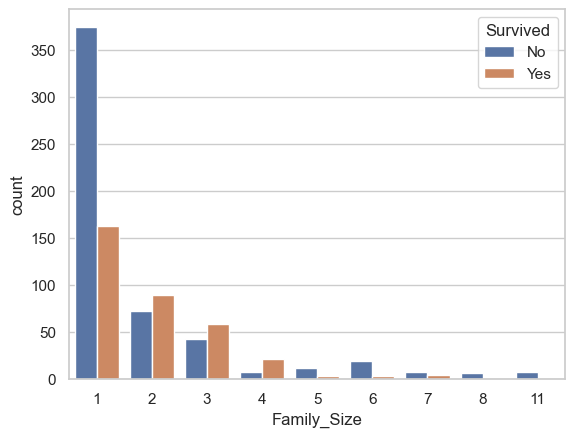

In [63]:
sns.countplot(data=train, x="Family_Size", hue="Survived")
plt.legend(['No', 'Yes'], title="Survived", loc='upper right')
plt.show()

In [64]:
train['Family'] = pd.cut(train['Family_Size'], bins=[0, 1, 4, 6, np.inf], labels=['Alone', 'Small', 'Medium', 'Large'])


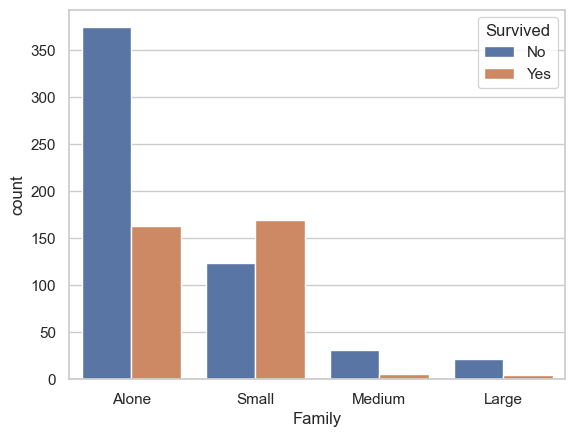

In [65]:
sns.countplot(data=train, x="Family", hue="Survived")
plt.legend(['No', 'Yes'], title="Survived", loc='upper right')
plt.show()

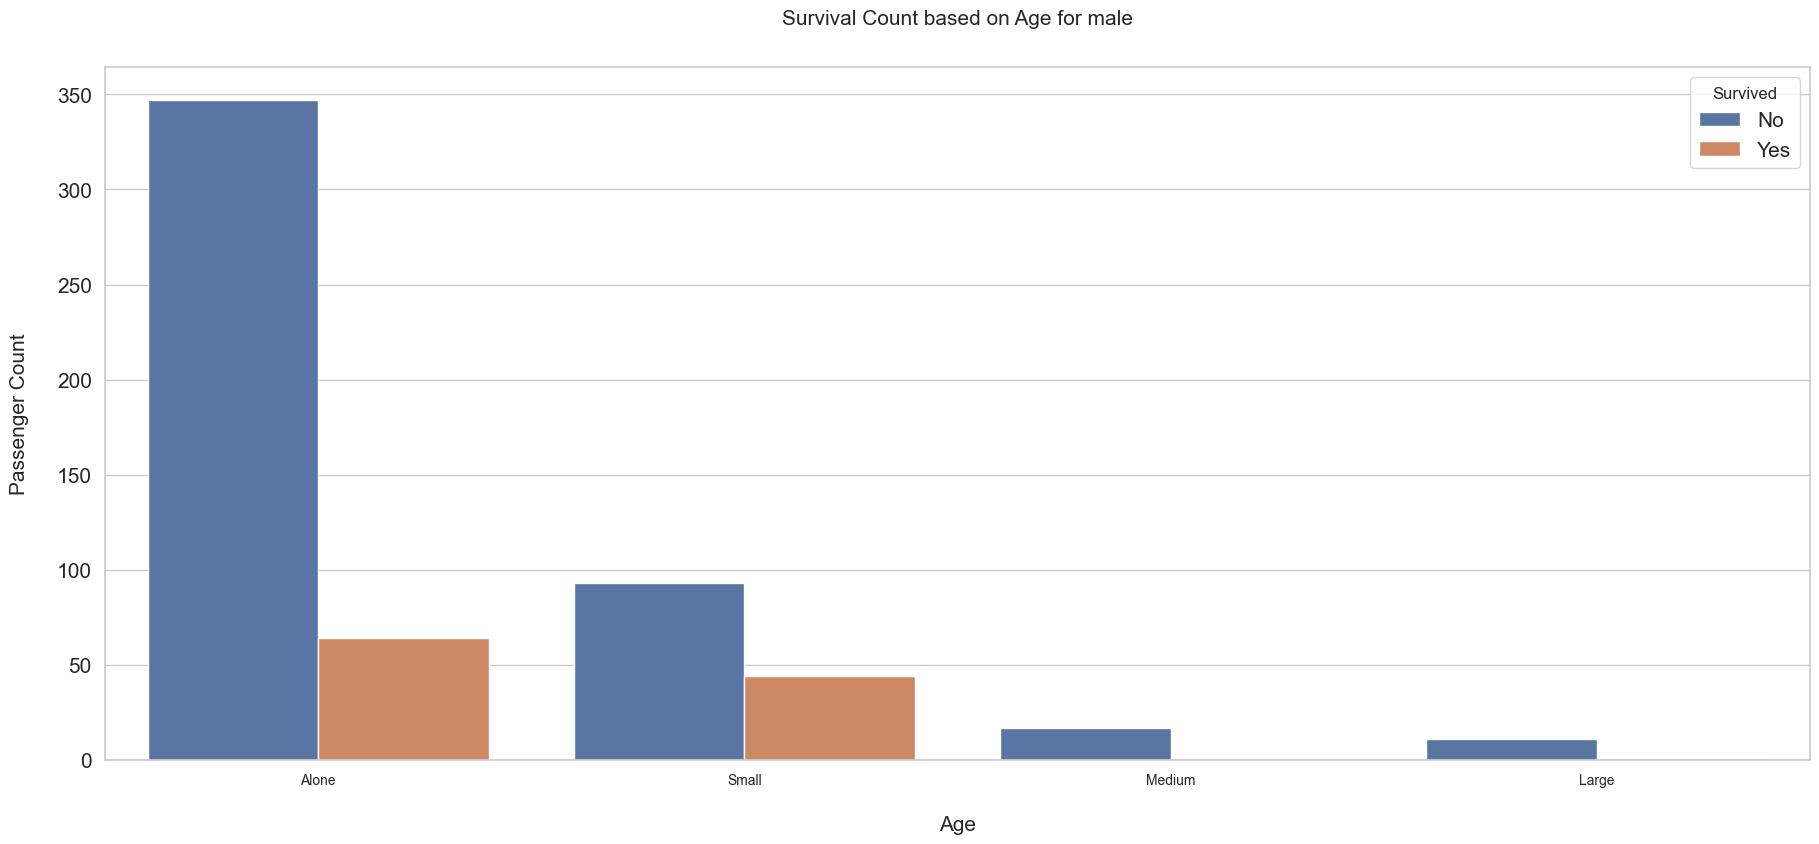

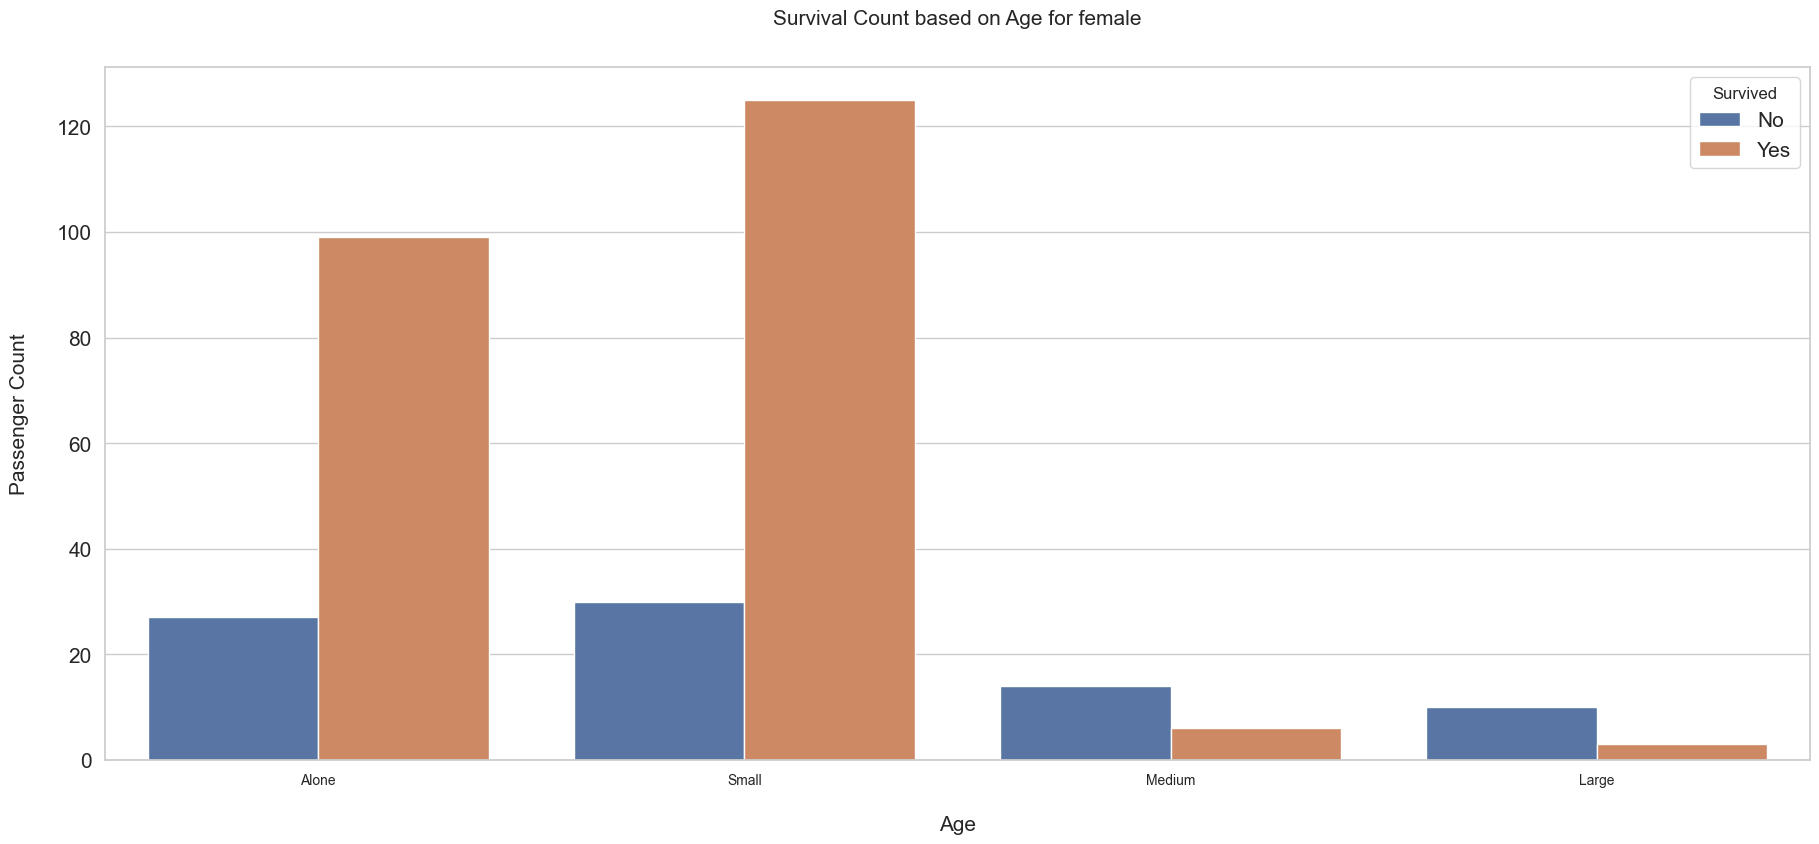

In [66]:
for gender in train['Sex'].unique():
    fig, axs = plt.subplots(figsize=(22, 9))
    sns.countplot(x='Family', hue='Survived', data=train[train['Sex'] == gender])

    plt.xlabel('Age', size=15, labelpad=20)
    plt.ylabel('Passenger Count', size=15, labelpad=20)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=15)

    plt.legend(['No', 'Yes'], title="Survived", loc='upper right', prop={'size': 15})
    plt.title(f'Survival Count based on Age for {gender}', size=15, y=1.05)
    plt.show()

#TODO: Write this better:
Family size played a significant role in the Titanic disaster, particularly in the context of evacuation priorities where women and children were given preference. Larger families, especially in third class, faced challenges in accessing lifeboats due to their socioeconomic status and lower deck accommodations. Additionally, the tendency of family members to stay together might have influenced their evacuation decisions, potentially affecting their survival chances.

#### **Ticket**

There are too many unique Ticket values to analyze, so grouping them up by their frequencies makes things easier.

How is this feature different than Family_Size? Many passengers travelled along with groups. Those groups consist of friends, nannies, maids and etc. They weren't counted as family, but they used the same ticket.

Why not grouping tickets by their prefixes? If prefixes in Ticket feature has any meaning, then they are already captured in Pclass or Embarked features because that could be the only logical information which can be derived from the Ticket feature.

In [68]:
train['Ticket_Frequency'] = train.groupby('Ticket')['Ticket'].transform('count')

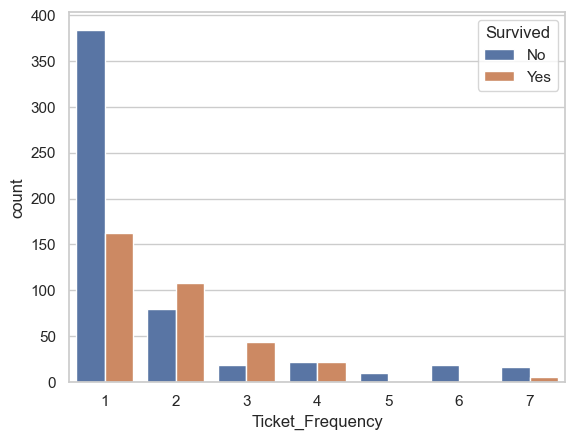

In [69]:
sns.countplot(data=train, x="Ticket_Frequency", hue="Survived")
plt.legend(['No', 'Yes'], title="Survived", loc='upper right')
plt.show()

In [70]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,Fare_Binned,Age_Binned,Family_Size,Family,Ticket_Frequency
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.2500,NaN,S,Mr,Lower,"(7.229, 7.75]","(19.0, 22.0]",2,Small,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.2833,C85,C,Mrs,Upper,"(55.9, 83.158]","(34.0, 40.5]",2,Small,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Lower,"(7.896, 8.05]","(22.0, 26.0]",1,Alone,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.1000,C123,S,Mrs,Upper,"(33.308, 55.9]","(34.0, 40.5]",2,Small,2
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.0500,NaN,S,Mr,Lower,"(7.896, 8.05]","(34.0, 40.5]",1,Alone,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.00,0,0,211536,13.0000,NaN,S,Other,Middle,"(10.5, 13.0]","(26.0, 28.72]",1,Alone,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00,0,0,112053,30.0000,B42,S,Miss,Upper,"(26.55, 33.308]","(16.0, 19.0]",1,Alone,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,16.12,1,2,W./C. 6607,23.4500,NaN,S,Miss,Lower,"(15.85, 24.0]","(16.0, 19.0]",4,Small,2
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00,0,0,111369,30.0000,C148,C,Mr,Upper,"(26.55, 33.308]","(22.0, 26.0]",1,Alone,1


In [71]:
train.isnull().any()

PassengerId         False
Survived            False
Pclass              False
Name                False
Sex                 False
Age                 False
SibSp               False
Parch               False
Ticket              False
Fare                False
Cabin                True
Embarked            False
Title               False
Deck                False
Fare_Binned         False
Age_Binned          False
Family_Size         False
Family              False
Ticket_Frequency    False
dtype: bool

In [72]:
train.corr(numeric_only=True)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Ticket_Frequency
PassengerId,1.000000,-0.005007,-0.035144,0.043183,-0.057527,-0.001652,0.012658,-0.040143,0.003355
Survived,-0.005007,1.000000,-0.338481,-0.076718,-0.035322,0.081629,0.257307,0.016639,0.038247
Pclass,-0.035144,-0.338481,1.000000,-0.404894,0.083081,0.018443,-0.549500,0.065997,-0.002633
Age,0.043183,-0.076718,-0.404894,1.000000,-0.276061,-0.192870,0.114634,-0.285033,-0.239951
SibSp,-0.057527,-0.035322,0.083081,-0.276061,1.000000,0.414838,0.159651,0.890712,0.661622
Parch,-0.001652,0.081629,0.018443,-0.192870,0.414838,1.000000,0.216225,0.783111,0.593076
Fare,0.012658,0.257307,-0.549500,0.114634,0.159651,0.216225,1.000000,0.217138,0.345541
Family_Size,-0.040143,0.016639,0.065997,-0.285033,0.890712,0.783111,0.217138,1.000000,0.748487
Ticket_Frequency,0.003355,0.038247,-0.002633,-0.239951,0.661622,0.593076,0.345541,0.748487,1.000000


## **Data Preprocessing for machine learning models**

Since generally we cannot pass strings to a machine learning models, we need to convert features like Sex, Embarked and so on into numeric values. 

This is more a limitation of the library that we are using than the machine algorithms themselves ([Scikit-learn Documentation Decision Trees](#Bibliography)).

For instance, algorithms like Logistic Regression require all categorical features in a dataset to be converted into a numerically evaluable format. In contrast, Decison Tree models have the inherent capability to process categorical variables without needing them to be numerical. However, in real-world applications, particularly when using scikit-learn, converting these categories to numerical formats is a common practice. This practice is more about aligning with the programming structure of these libraries, rather than being a necessity imposed by the Decison Tree algorithm ([Scikit-learn Documentation Decision Trees](#Bibliography)). This approach ensures broader compatibility and facilitates ease of use across various machine learning scenarios.


The following block is for preparing the dataset. The following steps will be carried out:

1) Feature selection
2) Encoding of nominal categorical features: Apply One-Hot Encoding to transform nominal categorical features (those without any intrinsic order) into a binary format
3) Encoding of ordinal features: Transform ordinal categorical features, which possess a logical order or ranking, into binary format by utilizing Label Encoding
4) Preparation of training and test sets


In [73]:
# Dropping unnecessary features
# drop_cols = ["PassengerId", "Name", 'Age', 'Ticket', 'Fare', 'Cabin', 'Ticket_Frequency', "Title", "Deck", "Fare_Binned", "Family_Size", "SibSp", "Parch"]
drop_cols = ["PassengerId", "Name", 'Age', 'Ticket', 'Fare', 'Cabin']
train_processed = train.drop(columns=drop_cols , axis=1)


#Adjusting the encoding
## One-Hot Encoding
# cols_one_hot_encoding = ["Sex", "Embarked", "Title"]
cols_one_hot_encoding = ["Embarked", "Title"]

train_processed = pd.get_dummies(train_processed, columns=cols_one_hot_encoding, drop_first=True)

##Label encoding
label_encoder = LabelEncoder()

cols_label_encoding = ["Sex","Deck", "Fare_Binned", "Age_Binned", "Family"]
#cols_label_encoding = ["Sex", "Age_Binned", "Family"]
for feature in cols_label_encoding:
    train_processed[feature] = label_encoder.fit_transform(train_processed[feature])
    le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print('Mapping target->label', le_name_mapping)


#Splitting the data into training and test data
X, y = train_processed.drop(columns=["Survived"], axis=1), train_processed[["Survived"]] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nControl the shapes of the training and test sets")
print('Shape X:', X.shape)
print('Shape y:', y.shape)
print('Shape  X_train:', X_train.shape)
print('Shape  X_test:', X_test.shape)
print('Shape  y_train:', y_train.shape)
print('Shape  y_test:', y_test.shape)

Mapping target->label {'female': 0, 'male': 1}
Mapping target->label {'Lower': 0, 'Middle': 1, 'Upper': 2}
Mapping target->label {Interval(-0.001, 7.229, closed='right'): 0, Interval(7.229, 7.75, closed='right'): 1, Interval(7.75, 7.896, closed='right'): 2, Interval(7.896, 8.05, closed='right'): 3, Interval(8.05, 10.5, closed='right'): 4, Interval(10.5, 13.0, closed='right'): 5, Interval(13.0, 15.85, closed='right'): 6, Interval(15.85, 24.0, closed='right'): 7, Interval(24.0, 26.55, closed='right'): 8, Interval(26.55, 33.308, closed='right'): 9, Interval(33.308, 55.9, closed='right'): 10, Interval(55.9, 83.158, closed='right'): 11, Interval(83.158, 512.329, closed='right'): 12}
Mapping target->label {Interval(0.419, 16.0, closed='right'): 0, Interval(16.0, 19.0, closed='right'): 1, Interval(19.0, 22.0, closed='right'): 2, Interval(22.0, 26.0, closed='right'): 3, Interval(26.0, 28.72, closed='right'): 4, Interval(28.72, 30.0, closed='right'): 5, Interval(30.0, 34.0, closed='right'): 6, 

In [74]:
train_processed.corr()

,Survived,Pclass,Sex,SibSp,Parch,Deck,Fare_Binned,Age_Binned,Family_Size,Family,Ticket_Frequency,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other
Survived,1.000000,-0.338481,-0.543351,-0.035322,0.081629,0.331964,0.320255,-0.033511,0.016639,0.246084,0.038247,0.003650,-0.149683,0.338468,-0.550009,0.344935,-0.056649
Pclass,-0.338481,1.000000,0.131900,0.083081,0.018443,-0.969965,-0.691988,-0.422845,0.065997,-0.186708,-0.002633,0.221009,0.074053,-0.014566,0.105913,-0.158279,-0.077608
Sex,-0.543351,0.131900,1.000000,-0.114631,-0.245489,-0.131918,-0.257943,0.112264,-0.200988,-0.293691,-0.154748,-0.074115,0.119224,-0.696282,0.886982,-0.552686,0.074518
SibSp,-0.035322,0.083081,-0.114631,1.000000,0.414838,-0.088450,0.366899,-0.250756,0.890712,0.402984,0.661622,-0.026354,0.068734,0.081986,-0.252275,0.062854,-0.037752
Parch,0.081629,0.018443,-0.245489,0.414838,1.000000,-0.019088,0.370985,-0.157925,0.783111,0.445335,0.593076,-0.081228,0.060814,0.099490,-0.345675,0.221318,-0.033916
Deck,0.331964,-0.969965,-0.131918,-0.088450,-0.019088,1.000000,0.668879,0.405263,-0.069988,0.176893,0.000926,-0.217463,-0.084360,0.010638,-0.110025,0.162654,0.081858
Fare_Binned,0.320255,-0.691988,-0.257943,0.366899,0.370985,0.668879,1.000000,0.168385,0.436101,0.502380,0.523226,-0.232756,-0.031083,0.082218,-0.310927,0.255120,0.005341
Age_Binned,-0.033511,-0.422845,0.112264,-0.250756,-0.157925,0.405263,0.168385,1.000000,-0.250280,-0.091318,-0.197977,-0.135945,0.035549,-0.341930,0.228199,0.239023,0.109561
Family_Size,0.016639,0.065997,-0.200988,0.890712,0.783111,-0.069988,0.436101,-0.250280,1.000000,0.497908,0.748487,-0.058592,0.077359,0.105738,-0.345115,0.153525,-0.042746
Family,0.246084,-0.186708,-0.293691,0.402984,0.445335,0.176893,0.502380,-0.091318,0.497908,1.000000,0.296174,-0.083774,-0.061085,0.018735,-0.365071,0.382062,-0.030963


## **Model**

Having navigated through exploratory data analysis and feature engineering, we now enter the predictive modeling stage where we transform our hypotheses and insights into actionable predictions. Our first focus is the Decision Tree algorithm, where we'll explore its workings in detail. This will set the foundation for efficiently applying and evaluating other algorithms. Let's dive in and see how well our data can predict outcomes!


The following is a list of algorithms that will be utilized to develop the predictive model:

- Decision tree
- Logistic Regression
- SVC classifier
- Ensemble random forest
- Gradient boosting machine
- Light GBM
- XgBoost Classifier


Model outputs are stored in 2 tables:

- model_params - This stores the model name and relevant score metrics
- Model prediction profile (model_predictions) - This stores the test set predictions from each model (best estimator)

### **Decision Tree**

#### **First Model**

In [75]:
clf = DecisionTreeClassifier()
clf = clf.fit(X=X_train, y=y_train)

y_pred = clf.predict(X_test)

#Different metrics
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred)
roc_auc = roc_auc_score(y_true=y_test, y_score=y_pred)

metrics = [f'Accuracy for Decision Tree is {accuracy}', 
           f'Precision for Decision Tree is {precision}',
           f'Recall for Decision Tree is {recall}',
           f'F1 for Decision Tree is {f1}',
           f'ROC/AUC for Decision Tree is {roc_auc}'
           ]

for metric in metrics:
    print(metric)

Accuracy for Decision Tree is 0.8379888268156425
Precision for Decision Tree is 0.8461538461538461
Recall for Decision Tree is 0.7432432432432432
F1 for Decision Tree is 0.7913669064748202
ROC/AUC for Decision Tree is 0.824002574002574


#### **Overfitting**

Overfitting occurs when a machine learning model captures not only the underlying patterns in the training data but also the noise or random fluctuations specific to that dataset. As a result, while the model performs exceptionally well on the training data, its ability to generalize to new, unseen data is significantly impaired, leading to poor performance on test or real-world data.

Decision Trees are prone to overfitting, especially when they are allowed to grow without constraints. Let's check how our model is doing.


In [76]:
clf = DecisionTreeClassifier()
clf = clf.fit(X=X_train, y=y_train)

y_pred = clf.predict(X_train)

#Different metrics
accuracy = accuracy_score(y_true=y_train, y_pred=y_pred)
precision = precision_score(y_true=y_train, y_pred=y_pred)
recall = recall_score(y_true=y_train, y_pred=y_pred)
f1 = f1_score(y_true=y_train, y_pred=y_pred)
roc_auc = roc_auc_score(y_true=y_train, y_score=y_pred)

metrics = [f'Accuracy for Decision Tree is {accuracy}', 
           f'Precision for Decision Tree is {precision}',
           f'Recall for Decision Tree is {recall}',
           f'F1 for Decision Tree is {f1}',
           f'ROC/AUC for Decision Tree is {roc_auc}'
           ]

for metric in metrics:
    print(metric)

Accuracy for Decision Tree is 0.9410112359550562
Precision for Decision Tree is 0.9788135593220338
Recall for Decision Tree is 0.8619402985074627
F1 for Decision Tree is 0.9166666666666665
ROC/AUC for Decision Tree is 0.9253395186231007


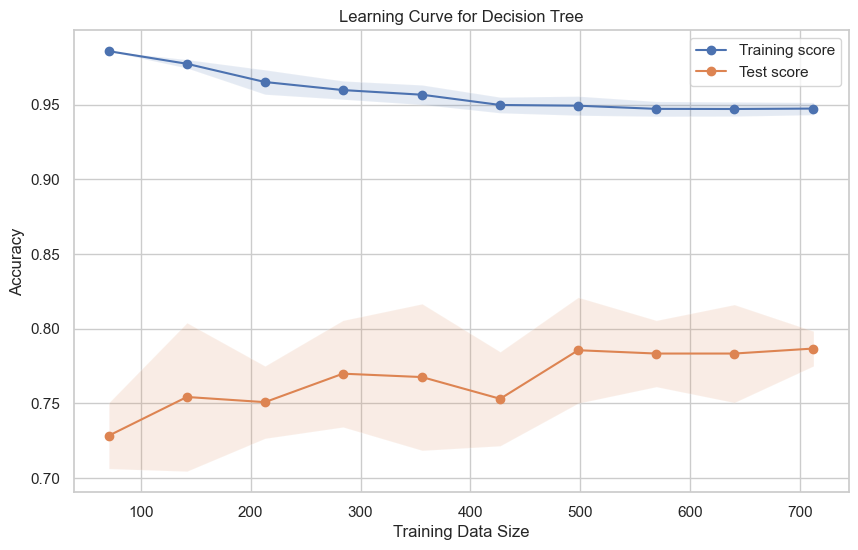

In [77]:
# Calculate learning curves
train_sizes, train_scores, test_scores = learning_curve(clf, X, y, cv=5, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)


test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training score",  marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)

plt.plot(train_sizes, test_mean, label="Test score", marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std,  alpha=0.15)

plt.title(f"Learning Curve for Decision Tree")
plt.xlabel("Training Data Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

We see signs of overfitting for both in the performance gap in our metrics as well as in the learning curve.

#### **Cross Validation**

Cross-validation is a statistical technique used in machine learning to assess the predictive performance of models and mitigate overfitting. It involves splitting the data into multiple segments, enabling comprehensive model evaluation, hyperparameter tuning, and ensuring model robustness across different subsets of data.



In [78]:
cv_result = cross_val_score(estimator=clf, X=X_test ,y=y_test, cv=5)

print(f'Accuracy of the five-fold cross-validation: {cv_result}\n Mean: {cv_result.mean()}\n Standard Deviation: {cv_result.std()}')

Accuracy of the five-fold cross-validation: [0.80555556 0.72222222 0.80555556 0.86111111 0.85714286]
 Mean: 0.8103174603174603
 Standard Deviation: 0.05015722320420623


#### **Hyperparameter Tuning using GridSearch**

GridSearchCV is a technique used in machine learning for tuning hyperparameters, the parameters that are not directly learnt within estimators. It works by systematically working through multiple combinations of parameter tunes, cross-validating as it goes to determine which tune gives the best performance.

Best paramaters are: {'max_depth': 6, 'min_samples_leaf': 8}


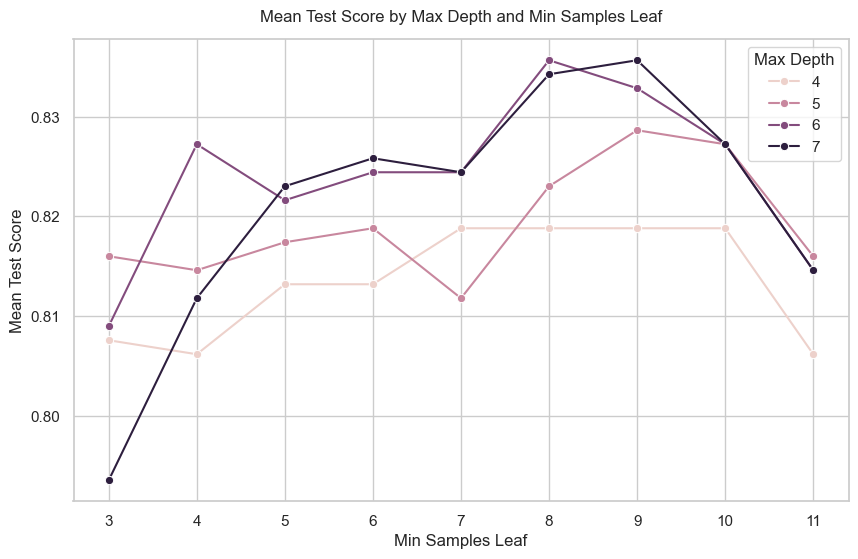

In [79]:
clf = DecisionTreeClassifier()
params = {'max_depth': range(4,8,1), 'min_samples_leaf' : range(3,12,1)}

clf_GCV = GridSearchCV(estimator=clf, param_grid=params, cv=2, scoring="accuracy", refit=True)

clf_GCV.fit(X_train, y_train)

print('Best paramaters are:',clf_GCV.best_params_)

#Plot accuracy for the different hyperparameter combinations
multi_index = pd.MultiIndex.from_product([params['max_depth'], params['min_samples_leaf']], 
                                         names=['max_depth', 'min_samples_leaf'])

# Creating a DataFrame with the MultiIndex
hyperparameter_grid= pd.DataFrame(index=multi_index)
hyperparameter_grid["mean_test_score"] = clf_GCV.cv_results_["mean_test_score"]
hyperparameter_grid["std_test_score"] = clf_GCV.cv_results_['std_test_score']


plt.figure(figsize=(10, 6))
sns.lineplot(data=hyperparameter_grid, x='min_samples_leaf', y='mean_test_score', hue='max_depth', marker='o')

plt.xlabel('Min Samples Leaf')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score by Max Depth and Min Samples Leaf', y=1.02)
plt.legend(title='Max Depth')
plt.grid(True)
plt.show()

#### **Visual representation of the decision tree**
The funciton 'plot_tree' helps to visually represent a decision tree model. It graphically displays the structure of the decision tree, showing the nodes, branches, and leaves, as well as the decisions or splits made at each node. This visualization helps in understanding how the decision tree model makes predictions based on the features of the input data.

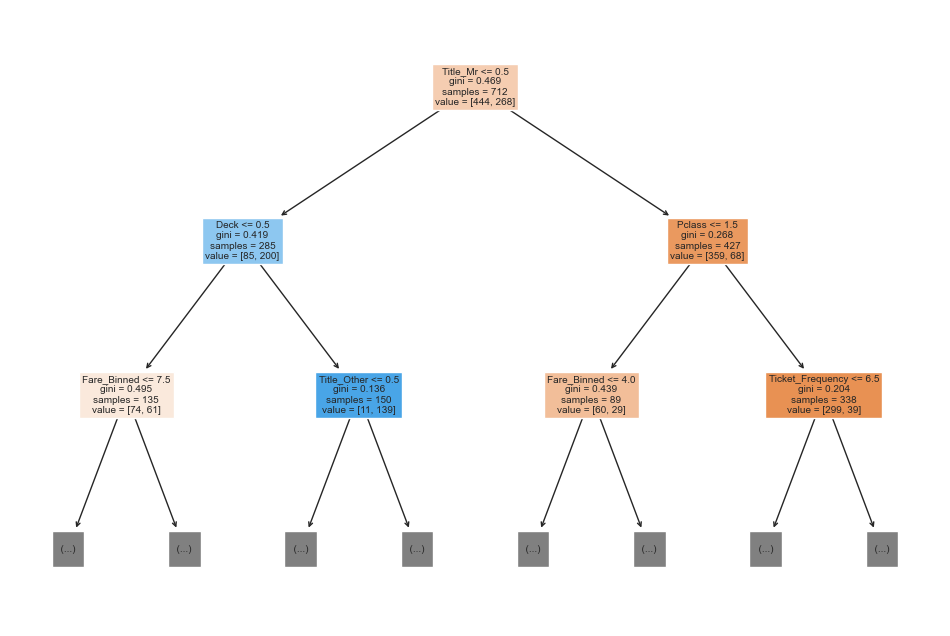

In [80]:
# Tree with the best parameters
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
tree = tree.fit(X=X_train, y=y_train)

y_pred = tree.predict(X_test)

plt.figure(figsize=(12, 8))
plot_tree(tree, max_depth=2, feature_names=X_train.columns, label='all', filled=True)
plt.show()

#### **Feature Importance**
Feature importance refers to techniques that assign a score to input features based on how useful they are at predicting a target variable. Tree-based models like Decision Trees support feature importance.

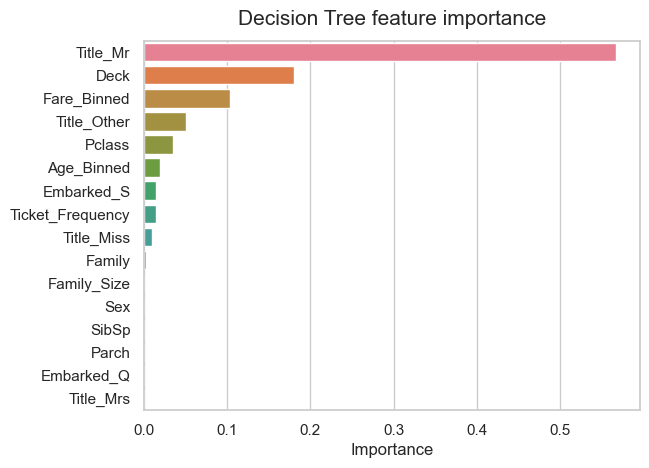

In [81]:
feature_importance = pd.DataFrame(data={'Feature': X_train.columns, 'Importance': tree.feature_importances_}).sort_values(by="Importance", ascending=False)
sns.barplot(data=feature_importance, x="Importance", y="Feature", hue="Feature")
plt.ylabel("")
plt.title('Decision Tree feature importance', size=15, y=1.02)
plt.show()

#### **Confusion Matrix**
A confusion matrix is a tool used in classification tasks to visualize the performance of a machine learning model. It is a table with four elements showing the number of true positives, false positives, true negatives, and false negatives. This matrix helps in assessing the model's accuracy, identifying the types of errors it makes, and informing further improvements.

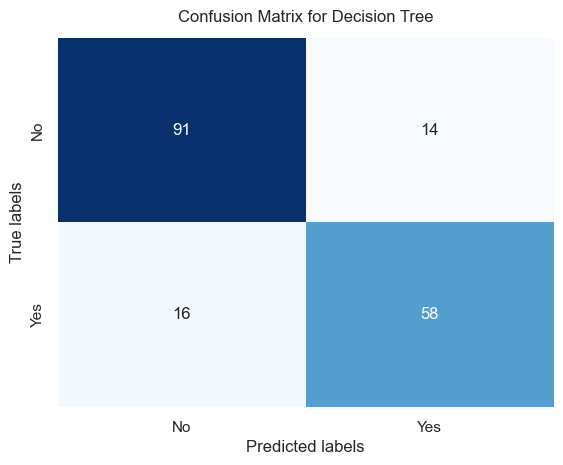

In [82]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred),  annot=True, fmt='g', cmap='Blues', cbar=False)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Decision Tree', y=1.02)

axis_labels = ['No', 'Yes']  
plt.xticks([0.5, 1.5], axis_labels)
plt.yticks([0.5, 1.5], axis_labels)
plt.show()

### **Various classification algorithms**
**Implementation Procedure**

1. Load the appropriate model
2. Apply the grid search parameters to tune the model
3. Generate scores for the training dataset
4. Derive predictions for the test dataset.
5. Incorporate the results into the designated output tables.


In [83]:
random_state = 10
# Creating a dictionary for the model parameters and classifier class instances
model_param_dict = \
{
'Logistic': [LogisticRegression(random_state=random_state, max_iter=400), {'C': np.exp(np.linspace(-2,2,5))}],
'SVC': [SVC(random_state =random_state), {'C': range(3,10,1)}],
'DTree' : [DecisionTreeClassifier(random_state=random_state), {'max_depth': range(2,7,1), 'min_samples_leaf' : range(3,12,1), 'max_leaf_nodes': range(2,12,1)}],
# 'RandomForest': [RandomForestClassifier(random_state =random_state), {'n_estimators': range(50,300,25), 'max_depth': range(4,7,1)}],
# 'GBM': [GradientBoostingClassifier(random_state=random_state), {'max_depth' : range(2,6,1)}],
# 'LGBM': [LGBMClassifier(random_state =random_state, importance_type="gain", verbosity=-1),{}],
# 'XgBoost': [XGBClassifier(eval_metric= 'logloss'), {}]
}

cv = None

# Creating empty model output storage objects
model_parameters = pd.DataFrame(data= None, index= list(model_param_dict.keys()), dtype= np.float32,
                             columns= ['Precision_Score', 'Recall_Score', 'F1_Score', 'ROC_AUC_Score', 'Accuracy_Score'])
model_parameters_test = pd.DataFrame(data= None, index= list(model_param_dict.keys()), dtype= np.float32,
                             columns= ['Precision_Score', 'Recall_Score', 'F1_Score', 'ROC_AUC_Score', 'Accuracy_Score'])
model_predictions = pd.DataFrame(data= None, index= None, columns= None, dtype= np.int32)

LogisticRegression(max_iter=400, random_state=10) {'C': array([0.13533528, 0.36787944, 1.        , 2.71828183, 7.3890561 ])}

Current model is Logistic


Best estimator is 
LogisticRegression(C=7.38905609893065, max_iter=400, random_state=10)



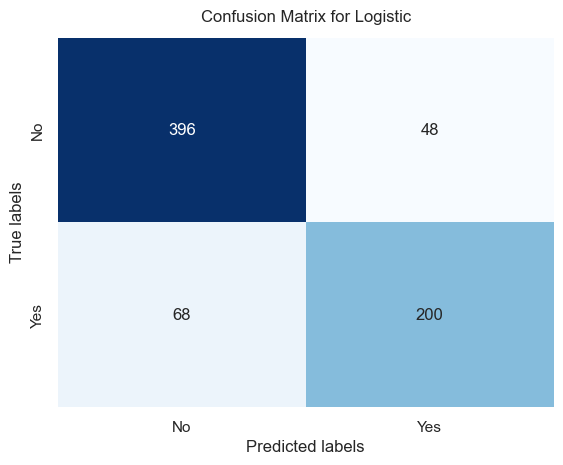

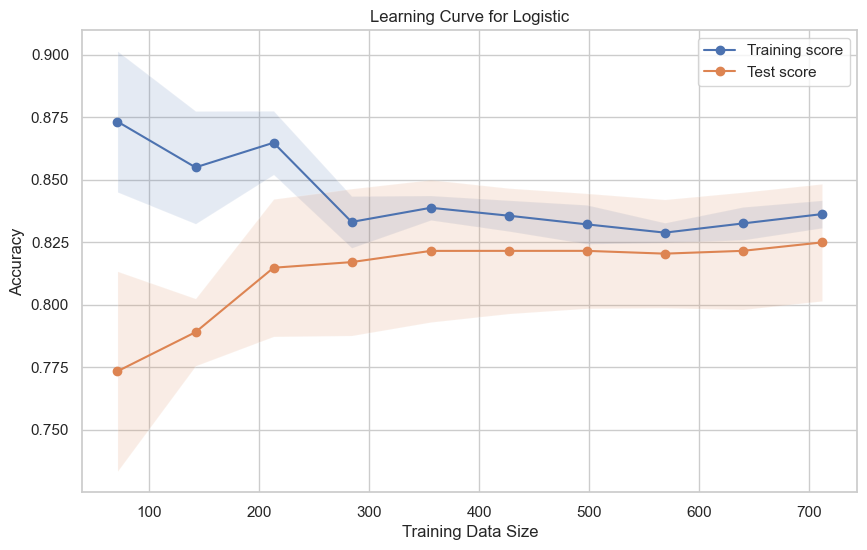

SVC(random_state=10) {'C': range(3, 10)}

Current model is SVC
Best estimator is 
SVC(C=9, random_state=10)



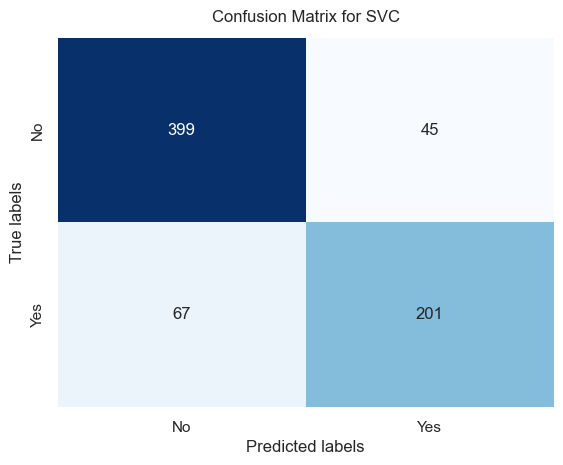

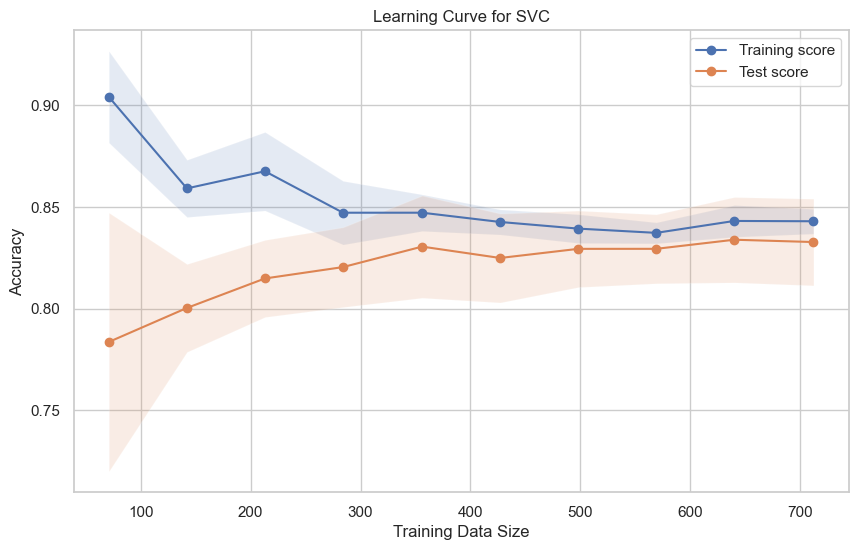

DecisionTreeClassifier(random_state=10) {'max_depth': range(2, 7), 'min_samples_leaf': range(3, 12), 'max_leaf_nodes': range(2, 12)}

Current model is DTree
Best estimator is 
DecisionTreeClassifier(max_depth=3, max_leaf_nodes=5, min_samples_leaf=3,
                       random_state=10)



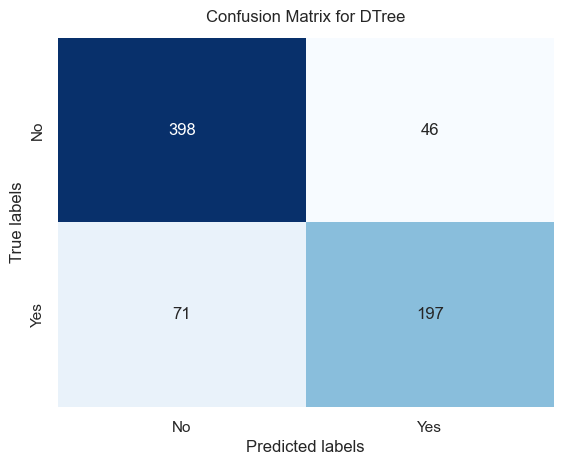

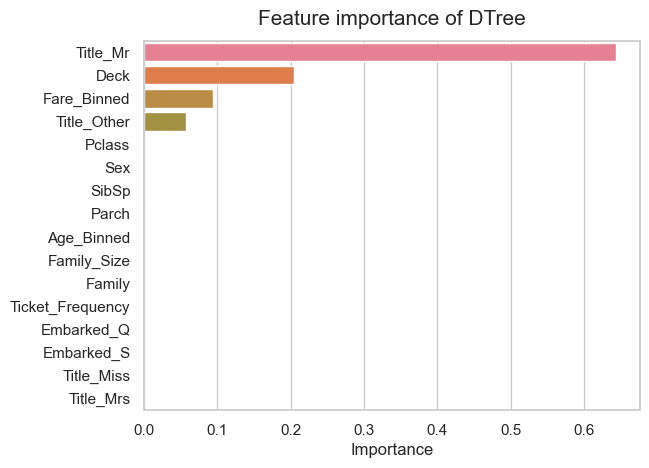

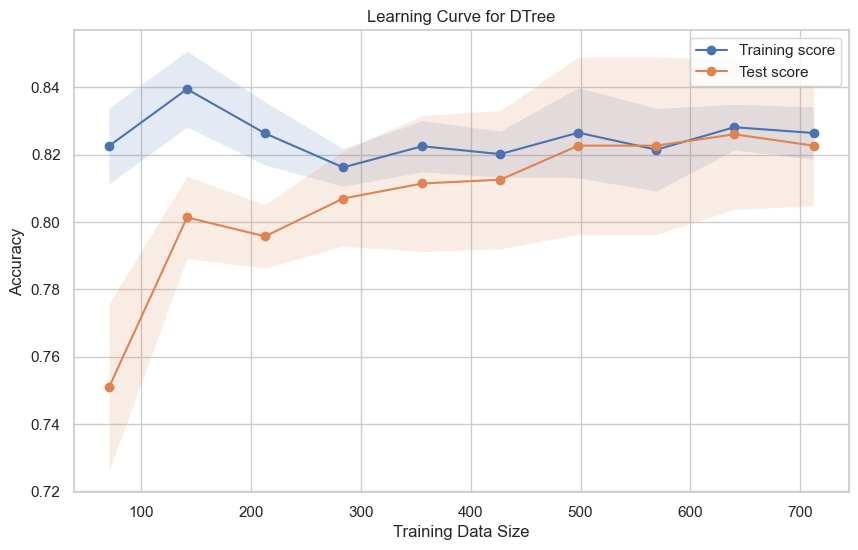



Training set scores across models:



,Precision_Score,Recall_Score,F1_Score,ROC_AUC_Score,Accuracy_Score
Logistic,80.65%,74.63%,77.52%,81.91%,83.71%
SVC,81.71%,75.00%,78.21%,82.43%,84.27%
DTree,81.07%,73.51%,77.10%,81.57%,83.57%




Test set scores across models:



,Precision_Score,Recall_Score,F1_Score,ROC_AUC_Score,Accuracy_Score
Logistic,80.28%,77.03%,78.62%,81.85%,82.68%
SVC,81.16%,75.68%,78.32%,81.65%,82.68%
DTree,80.60%,72.97%,76.60%,80.30%,81.56%


In [84]:
supports_feature_importance = ["DTree", "RandomForest", "GBM", "LGBM", "XgBoost"]

for model, model_params in model_param_dict.items():
    print(model_params[0], model_params[1])
    print(colored(f"\nCurrent model is {model}", color='red', attrs=['bold', 'dark']))
    grid = GridSearchCV(estimator=model_params[0], param_grid=model_params[1], scoring='accuracy', refit=True, cv=cv)
    grid.fit(X_train, y_train["Survived"].values)
    print(f"""Best estimator is \n{grid.best_estimator_}\n""")
    
    y_train_pred = grid.predict(X_train)
    y_test_pred = grid.predict(X_test)
   
   
    #Display confusion matrix
    sns.heatmap(confusion_matrix(y_true=y_train['Survived'].values, y_pred=y_train_pred),  annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {model}', y=1.02)
    axis_labels = ['No', 'Yes']  
    plt.xticks([0.5, 1.5], axis_labels)
    plt.yticks([0.5, 1.5], axis_labels)
    plt.show()

    #Display feature importance
    if model in supports_feature_importance:
        best_model = grid.best_estimator_
        best_model.fit(X_train, y_train["Survived"].values)

        # for LGBM feature importance is not automatically normalized
        if model == "LGBM":
            feature_importance = pd.DataFrame(data={'Feature': X_train.columns, 'Importance': best_model.feature_importances_ / sum(best_model.feature_importances_)}).sort_values(by="Importance", ascending=False)
        else:
            feature_importance = pd.DataFrame(data={'Feature': X_train.columns, 'Importance': best_model.feature_importances_}).sort_values(by="Importance", ascending=False)
                  
        sns.barplot(data=feature_importance, x="Importance", y="Feature", hue="Feature")
        plt.ylabel("")
        plt.title(f'Feature importance of {model}', size=15, y=1.02)
        plt.show()

    
    # Display learning curve
    train_sizes, train_scores, test_scores = learning_curve(grid.best_estimator_, X, y, cv=5, n_jobs=-1, 
                                                            train_sizes=np.linspace(0.1, 1.0, 10))

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)


    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label="Training score",  marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)

    plt.plot(train_sizes, test_mean, label="Test score", marker='o')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std,  alpha=0.15)

    plt.title(f"Learning Curve for {model}")
    plt.xlabel("Training Data Size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    model_parameters.loc[model] = (precision_score(y_true=y_train['Survived'].values, y_pred=y_train_pred),
                                  recall_score(y_true=y_train['Survived'].values, y_pred=y_train_pred),
                                  f1_score(y_true=y_train['Survived'].values, y_pred=y_train_pred),
                                  roc_auc_score(y_true=y_train['Survived'].values, y_score=y_train_pred),
                                  accuracy_score(y_true=y_train['Survived'].values, y_pred=y_train_pred)
                                 )
    
    model_parameters_test.loc[model] = (precision_score(y_true=y_test['Survived'].values, y_pred=y_test_pred),
                                  recall_score(y_true=y_test['Survived'].values, y_pred=y_test_pred),
                                  f1_score(y_true=y_test['Survived'].values, y_pred=y_test_pred),
                                  roc_auc_score(y_true=y_test['Survived'].values, y_score=y_test_pred),
                                  accuracy_score(y_true=y_test['Survived'].values, y_pred=y_test_pred)
                                 )
    
    model_predictions = pd.concat((model_predictions, pd.DataFrame(data=grid.predict(X_test), index=X_test.index, columns =[model], dtype=np.int32)),
                             axis=1, join='outer')
print(colored(f"\n\nTraining set scores across models:\n", color = 'blue', attrs= ['bold', 'dark']))
display(model_parameters.style.format('{:.2%}'))
print(colored(f"\n\nTest set scores across models:\n", color = 'blue', attrs= ['bold', 'dark']))
display(model_parameters_test.style.format('{:.2%}'))

# Bibliography

Cukierski, Will (2012). "Titanic - Machine Learning from Disaster". Publisher: Kaggle. URL: [https://kaggle.com/competitions/titanic](https://kaggle.com/competitions/titanic).

Gunesevitan, "Titanic: Advanced Feature Engineering Tutorial", Kaggle, available at: [https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial) (accessed on [02.01.2024]).

Scikit-learn Documentation Decision Trees, "Decision Trees — scikit-learn 1.3.2 documentation", available at: [https://scikit-learn.org/stable/modules/tree.html#tree](https://scikit-learn.org/stable/modules/tree.html#tree) (accessed on 05.01.2024).

References
This notebook has been created based on great work done solving the Titanic competition and other sources.

A journey through Titanic
Getting Started with Pandas: Kaggle's Titanic Competition
Titanic Best Working Classifier

## Solve this observation: Nevertheless, one notable observation emerges. The embarkation location appears to influence survival rates within the third passenger class. Approximately 70% of women boarding in Queenstown and Cherbourg survived, contrasting with a lower survival rate of 38% for those embarking in Southampton. One can assume a trend based on embarkation location for males as well.

In [85]:
grouped_sex_pclass_embarked_deck_df.loc["female"]

NameError: name 'grouped_sex_pclass_embarked_deck_df' is not defined

In [ ]:
grouped_sex_pclass_embarked_deck_df.loc["female", "3"]

Still unclear why so many more women died embarking in S.

In [ ]:
plot_data.groupby(by=["Deck","Embarked", "Survived"])["Deck"].count().unstack('Survived').plot.bar()

The high mortality rate among passengers embarking in Southampton on the Titanic can be attributed to several factors. Firstly, Southampton was the ship's initial departure point, and a significant portion of the crew, including crucial operational staff, boarded here. When the ship struck an iceberg and started sinking, these crew members played vital roles in managing the emergency, which increased their chances of being on the ship during the crisis.

Additionally, many of the passengers embarking in Southampton were in the lower classes, and during the evacuation, priority was given to first-class passengers and women and children. This prioritization, combined with the fact that lower-class accommodations were situated farther from lifeboat stations, likely contributed to a higher casualty rate among those embarking in Southampton.

In [ ]:
sns.countplot(data=plot_data, x="Deck", hue="Embarked")

The Titanic disaster is one of the most infamous shipwrecks in history. Out of the 2,224 passengers and crew aboard, only 710 individuals managed to survive. The survival rate was significantly influenced by various factors, including gender, age, socioeconomic status, and the cabin's location.

Further analysis reveals that certain groups, such as women, children, and the upper-class passengers, had a higher likelihood of survival. These trends shed light on the critical role played by societal norms and priorities during this tragic event. By delving deeper into the data, we can uncover valuable insights into the intricate dynamics that determined the fate of the passengers aboard the ill-fated Titanic.

The sinking of the RMS Titanic in 1912 remains one of the most infamous maritime disasters in history, claiming the lives of over 1,500 people. Amidst the tragic event, the socioeconomic dynamics aboard the ship played a crucial role in shaping the fate of its passengers.

The Titanic, known for its opulence and luxury, was a microcosm of the socio-economic disparities prevalent during the early 20th century. Divided into distinct passenger classes, the ship catered to a diverse range of travelers, each with varying privileges and accommodations reflective of their social standing.

At the pinnacle were the first-class passengers, comprising wealthy industrialists, businessmen, and celebrities. They enjoyed the most lavish amenities, including luxurious cabins, gourmet dining, and exclusive access to the ship's finest facilities. Their status granted them priority during the chaotic evacuation, leading to a higher survival rate compared to those in the lower classes.

The second-class passengers, comprising middle-class professionals and tourists, experienced a notable disparity in comfort compared to their first-class counterparts. While their accommodations were more modest, they still enjoyed relatively decent facilities and services. During the evacuation, some second-class passengers found themselves in a slightly better position compared to those in third class, albeit still facing challenges in reaching the lifeboats.

In contrast, the third-class passengers, consisting of immigrants and individuals seeking a better life in America, endured cramped living quarters and limited access to the ship's amenities. This group faced significant obstacles during the evacuation, with many struggling to access the lifeboats due to their location on the lower decks and their restricted access to crucial information and resources.

The tragedy of the Titanic underscored the striking disparities in treatment and survival prospects based on social class. While some accounts of heroism and sacrifice emerged from all classes, the overwhelming statistics indicate that the likelihood of survival was skewed in favor of those in the higher echelons of society. This stark demonstration of the impact of socio-economic status on the outcomes of a disaster has since served as a poignant reminder of the need for equitable access to resources and safety measures, regardless of one's social standing.

In [ ]:
train.describe(include=["number"])

In [ ]:
train.describe(include=["object"])

In [ ]:
train.columns

In [ ]:
sns.scatterplot(data=train, x="Age", y="Survived", hue="Sex")

In [ ]:
sns.scatterplot(data=train, x="Age", y="Fare", hue="Survived")

In [ ]:
grouped_sex_pclass_embarked_deck_df  = train.groupby(by=['Sex', 'Pclass', 'Embarked', 'Deck']).agg(Survivors = pd.NamedAgg(column='Survived', aggfunc="sum"), Passengers = pd.NamedAgg(column='Survived', aggfunc="size"))
grouped_sex_pclass_embarked_deck_df['Survival_Rate'] = grouped_sex_pclass_embarked_deck_df['Survivors'] / grouped_sex_pclass_embarked_deck_df['Passengers']

print('Survival rate by Sex, Passenger Class and Embarked and Deck')
display(grouped_sex_pclass_embarked_deck_df.style.format({'Survival_Rate':'{:.2%}'}))

In [ ]:
sns.boxplot(data=train, x="Sex", y="Survived")

In [ ]:
sns.pairplot(data=train, hue="Sex")